Looking for flares in all the STIS data.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from matplotlib import cm
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
import matplotlib.patches as mpatches
from astropy.modeling import models, fitting
from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [15]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/'

In [65]:
tags = glob.glob('{}*tag.fits'.format(path))

In [70]:
g140ms = []
g140m_stars = []
e140ms = []
e140m_stars = []
g140ls = []
g140l_stars = []
g230ls = []
g230l_stars = []
for tag in tags:
    grating = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating == 'E140M':
        e140ms.append(tag)
        e140m_stars.append(star)
    elif grating == 'G140M':
        g140ms.append(tag)
        g140m_stars.append(star)
    elif grating == 'G140L':
        g140ls.append(tag)
        g140l_stars.append(star)
    elif grating == 'G230L':
        g230ls.append(tag)
        g230l_stars.append(star)
        
    else:
        print ('Unknown grating: {}'.format(grating))

g140m_stars = np.unique(g140m_stars)
g140l_stars = np.unique(g140l_stars)
e140m_stars = np.unique(e140m_stars)


In [13]:
outpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/'

In [9]:
import stistools


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [81]:
t_bin = 20 #in seconds
grating = 'g140m'

use_tags = []
stars = []

for tag in tags:
    grating_i = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating_i.lower() == grating:
        use_tags.append(tag)
        stars.append(star)

stars = np.unique(stars)
# print(stars)

In [82]:

for tag in use_tags:
    print(tag)
    rootname = fits.getheader(tag)['ROOTNAME'] #find the rootname of the tagfile to name the output file
    exptime = fits.getheader(tag)['TEXPTIME']
    n_bins = int(exptime/t_bin) #use the exposure time to tell inttag how many time bins there will be
    print('n_bins = {}'.format(n_bins) )
    outfile = '{}{}/{}_{}s_raw.fits'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    if os.path.exists(outfile):
        os.remove(outfile)
    stistools.inttag.inttag(tag, outfile, rcount = n_bins, increment = t_bin, verbose=False) #change verbose to true to diagnose problems

/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm03040_tag.fits
n_bins = 130
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm06040_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm03050_tag.fits
n_bins = 130
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm06050_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm12030_tag.fits
n_bins = 29
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm12040_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm15030_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm15040_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm15050_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm18030_tag.fits
n_bins = 24
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/

In [83]:
os.environ['oref'] = path 

In [85]:
raws = glob.glob('{}{}/*raw.fits'.format(outpath, grating))
raws

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm03040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm03050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm06040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm06050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm12030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm12040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm15030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm15040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm15050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140m/odlm18030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hdda

In [24]:
for raw in raws:
    rootname = fits.getheader(raw)['ROOTNAME'] 
    outname = '{}{}/{}_{}s'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    if os.path.exists(outname):
        os.remove(outname)
    stistools.calstis.calstis(raw, outroot = outname, wavecal='{}{}_wav.fits'.format(path, rootname), trailer='{}_{}s_extract.trl'.format(rootname,t_bin))

In [87]:
new_x1ds = glob.glob('{}{}/*{}s*x1d.fits'.format(outpath, grating, t_bin))
new_x1ds

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04010_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04030_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04040_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12070_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22010_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22020_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hdda

In [28]:
# for x in new_x1ds:
#     fig, ax = plt.subplots()
#     hdul = fits.open(x)
#     print(hdul[0].header['ROOTNAME'])
#     for ext in hdul[1::]: #spectra in every extension after the first
#         data = ext.data[0]
#         ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
#         # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
#         ax.set_ylim(0, 1.1*max(data['FLUX']))
#         # plt.show()
#     hdul.close()
#     plt.show()
    

GJ676A


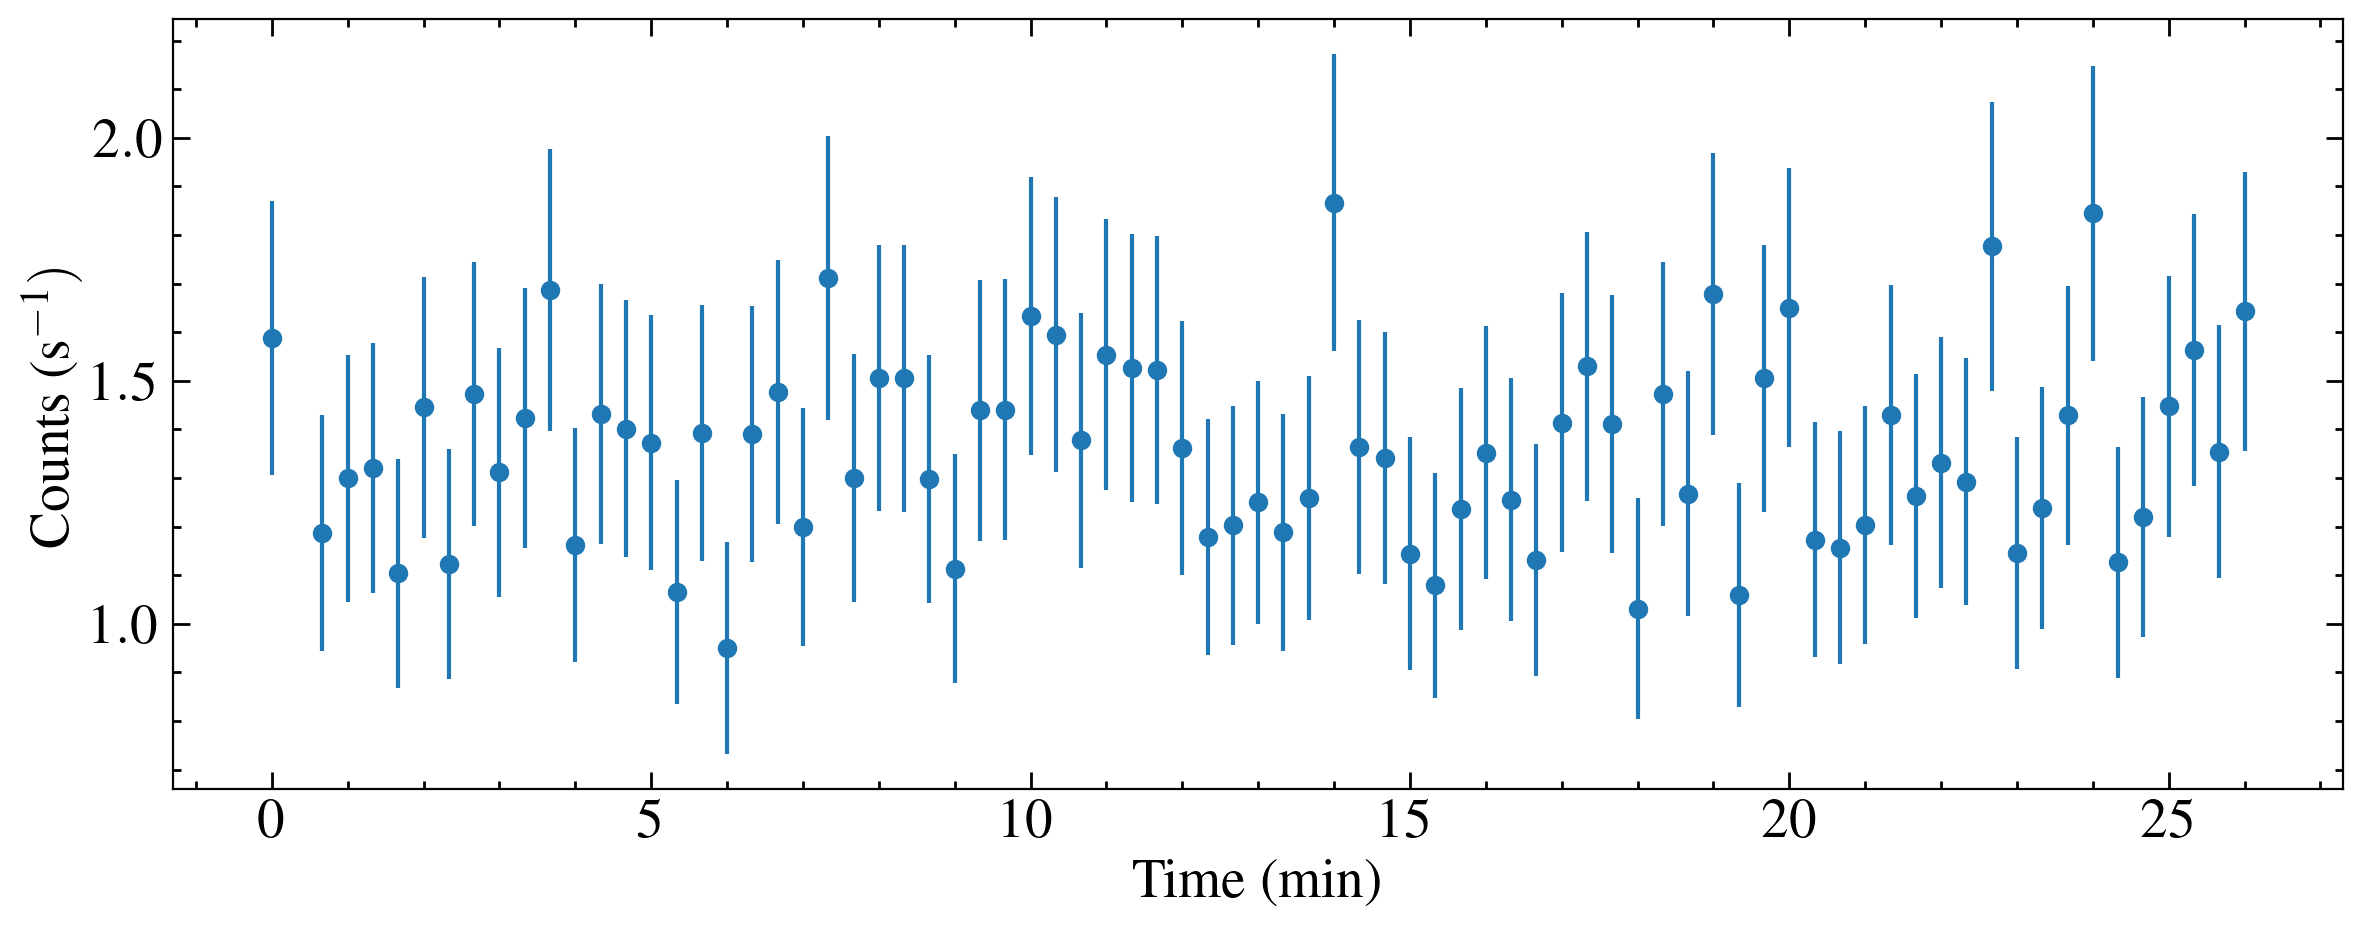

GJ676A


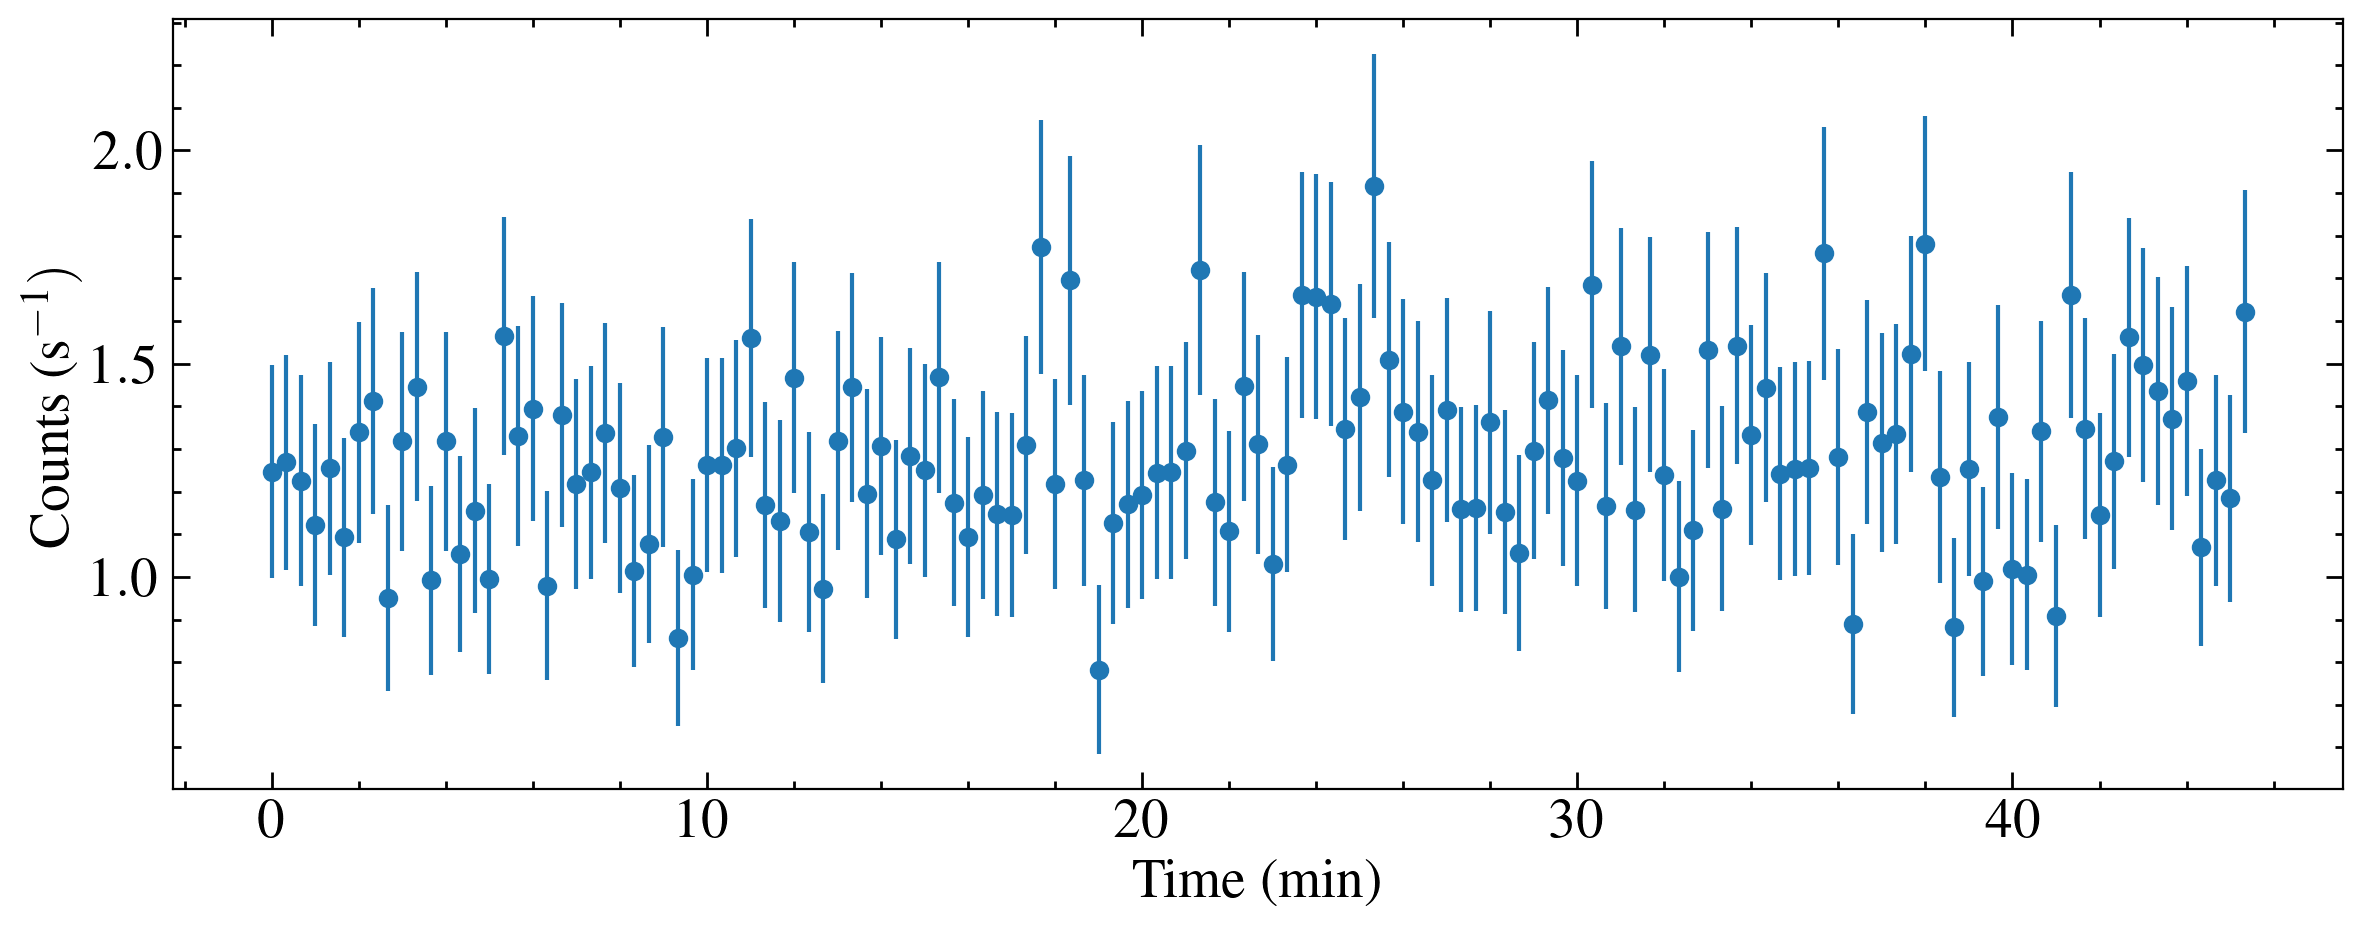

GJ676A


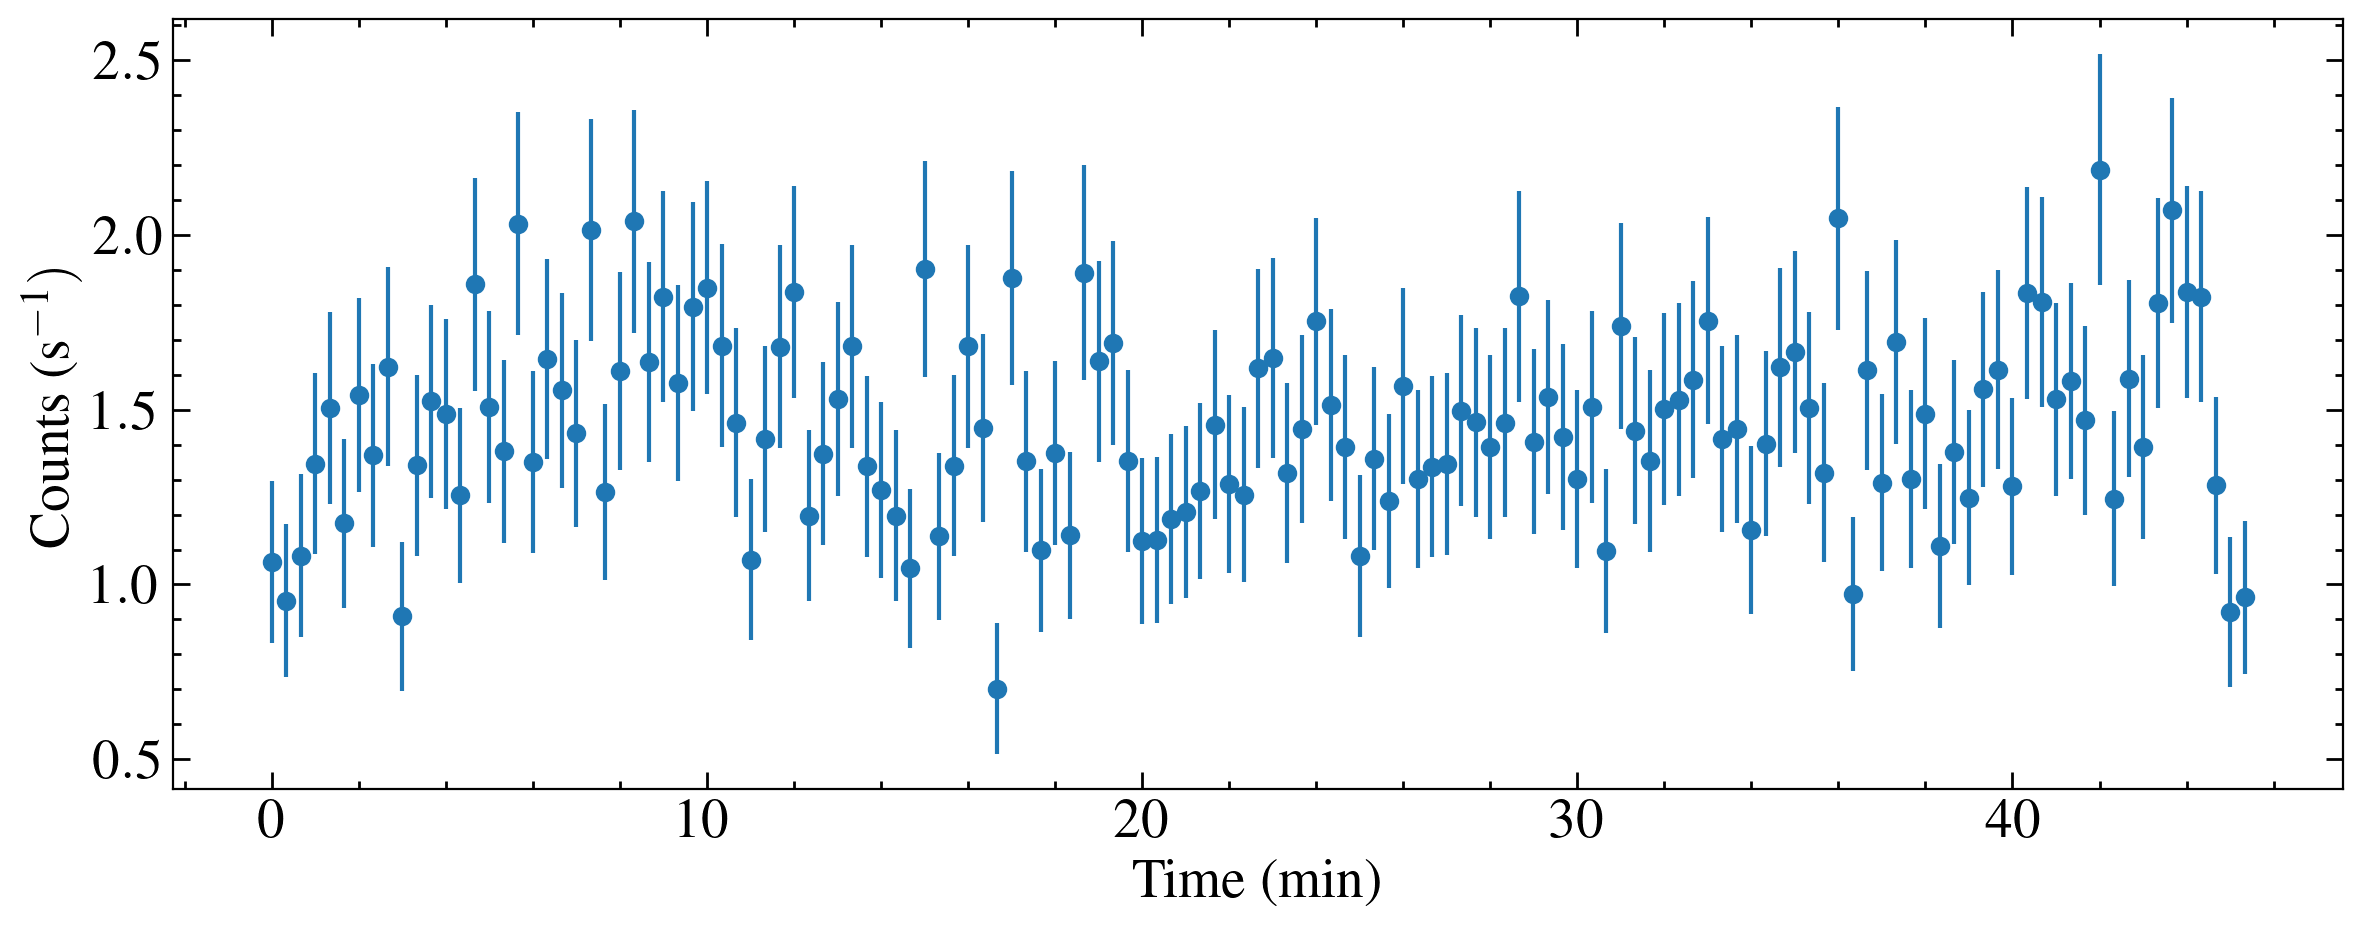

GJ649


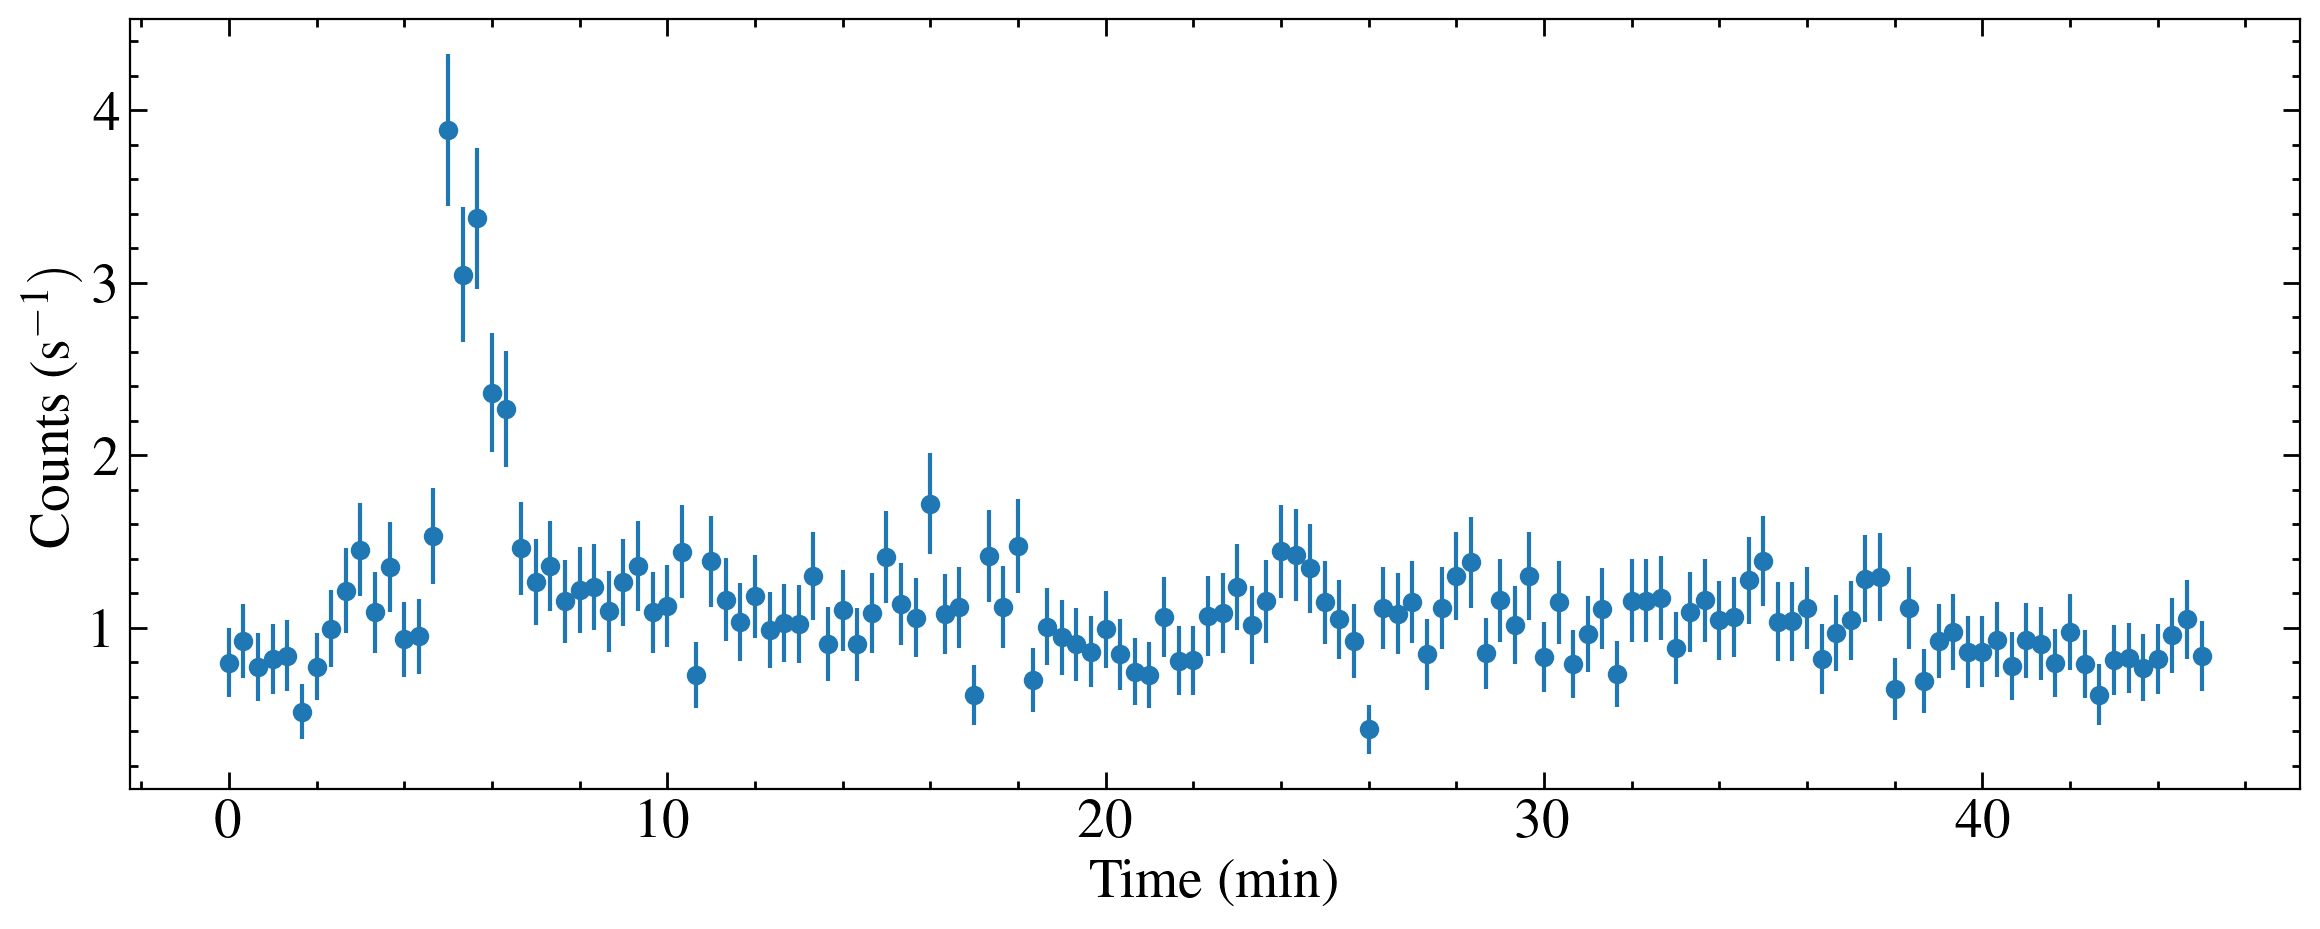

GJ649


/tmp/ipykernel_22885/3658747120.py:36: RuntimeWarning: invalid value encountered in scalar power
  ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts


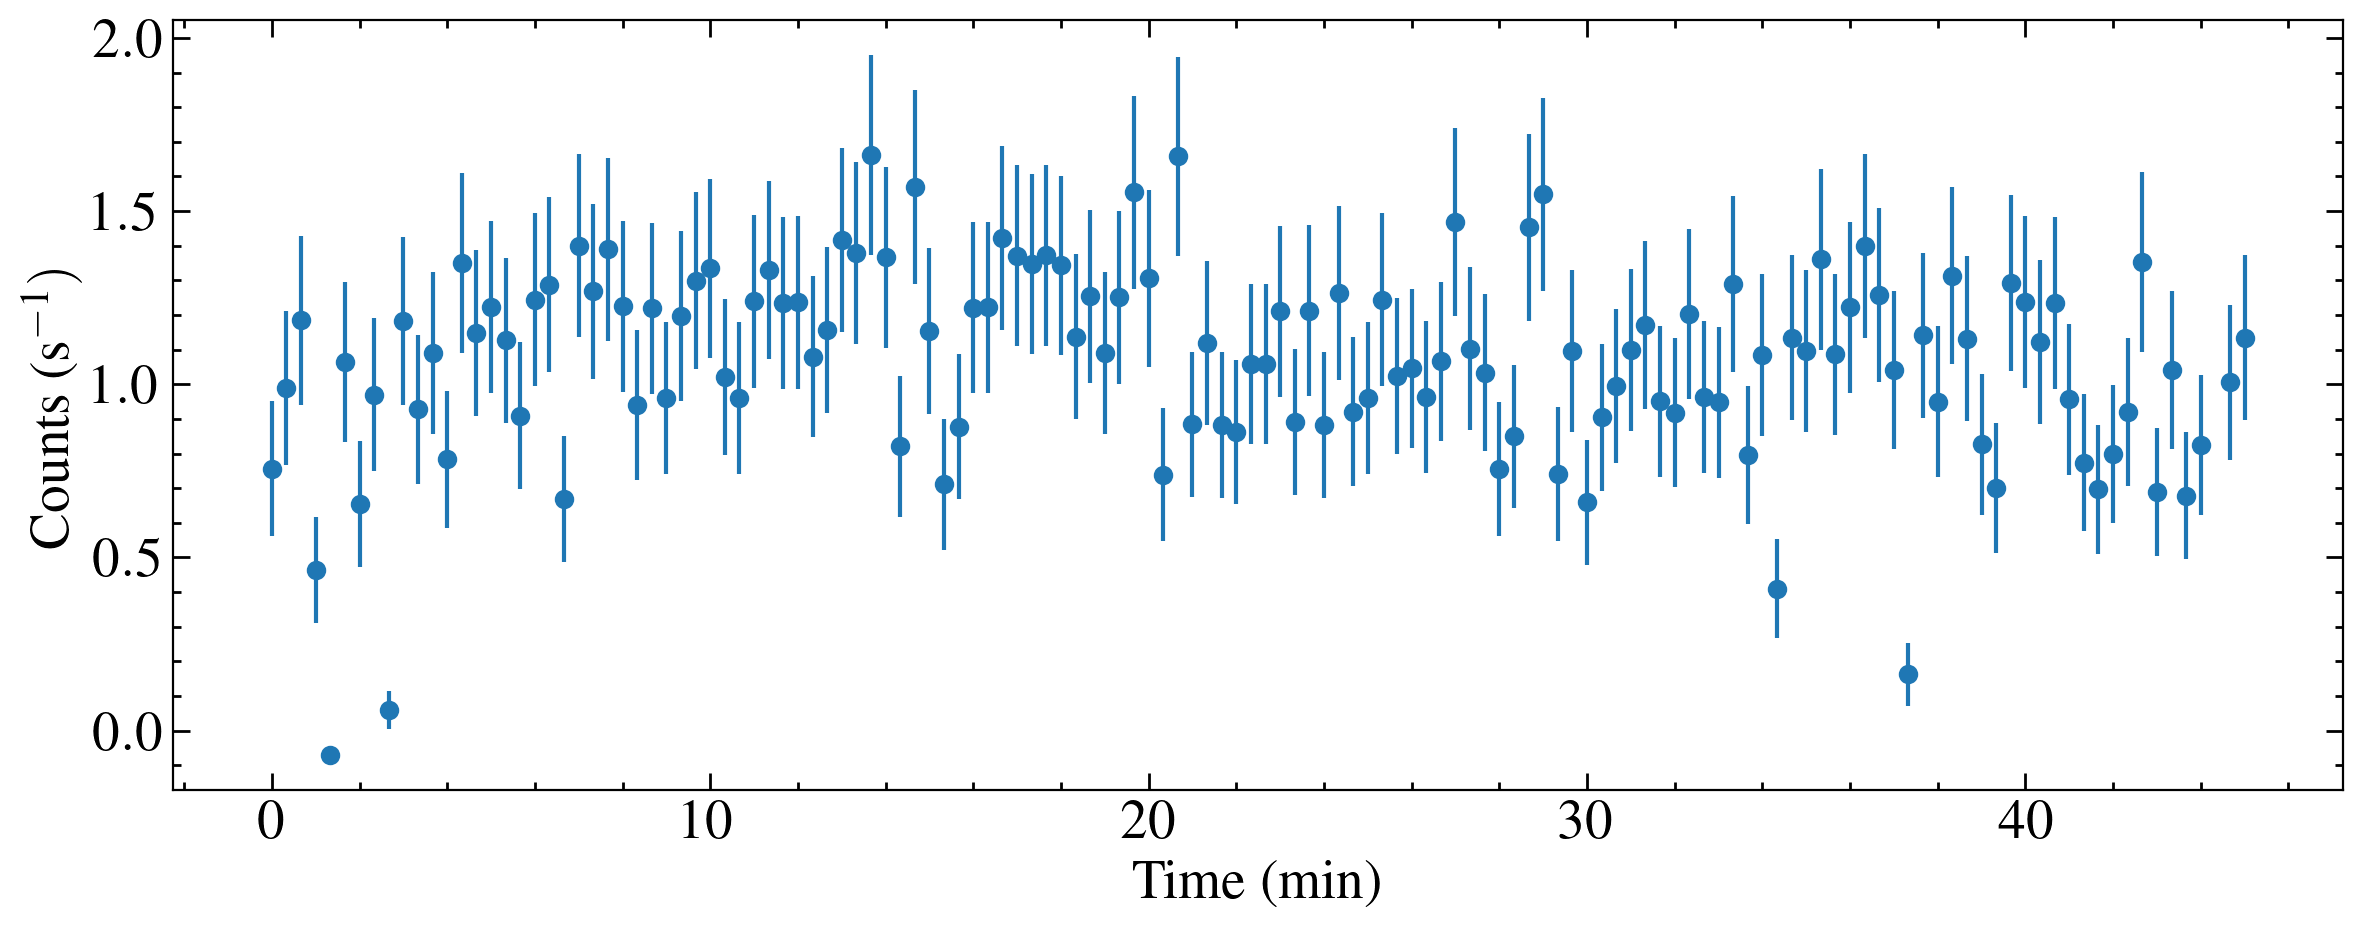

GJ649


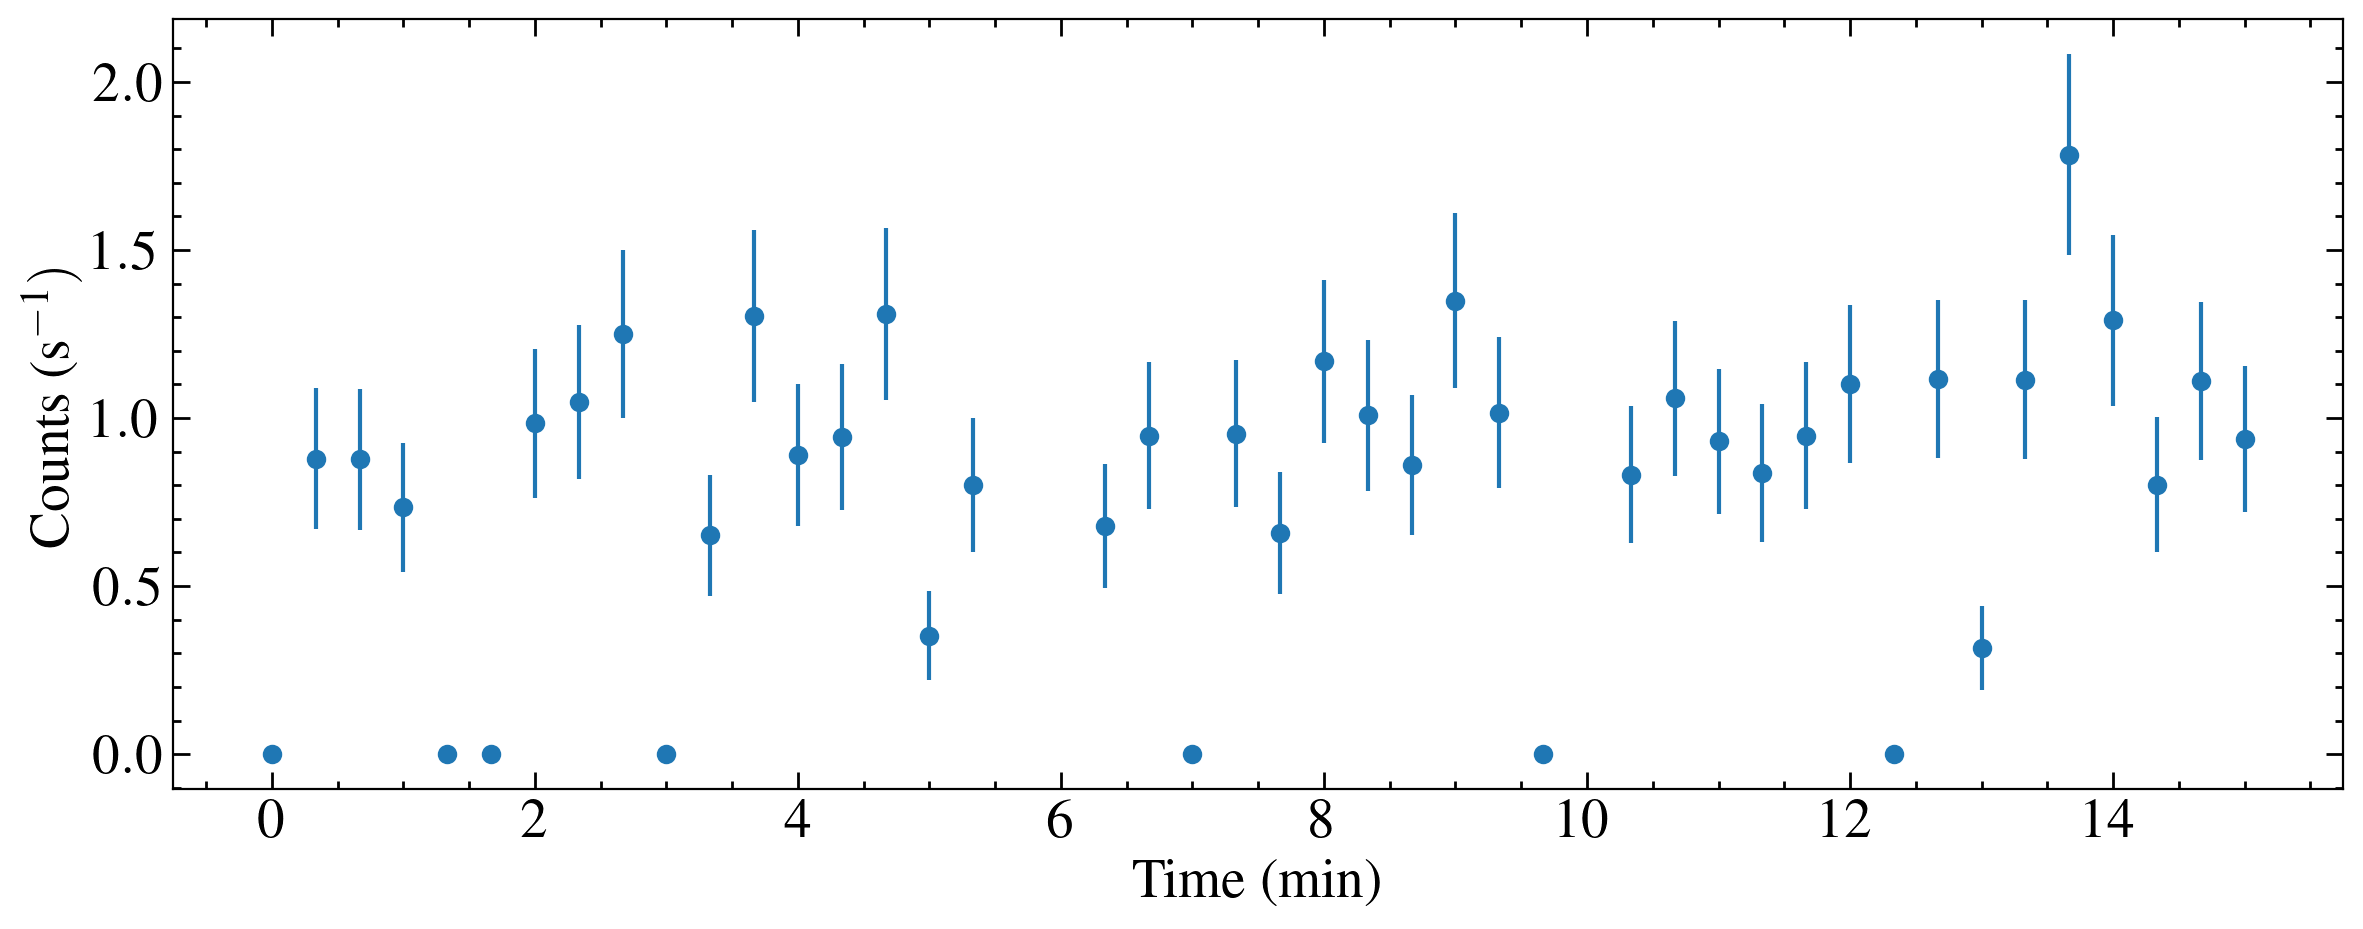

GJ674


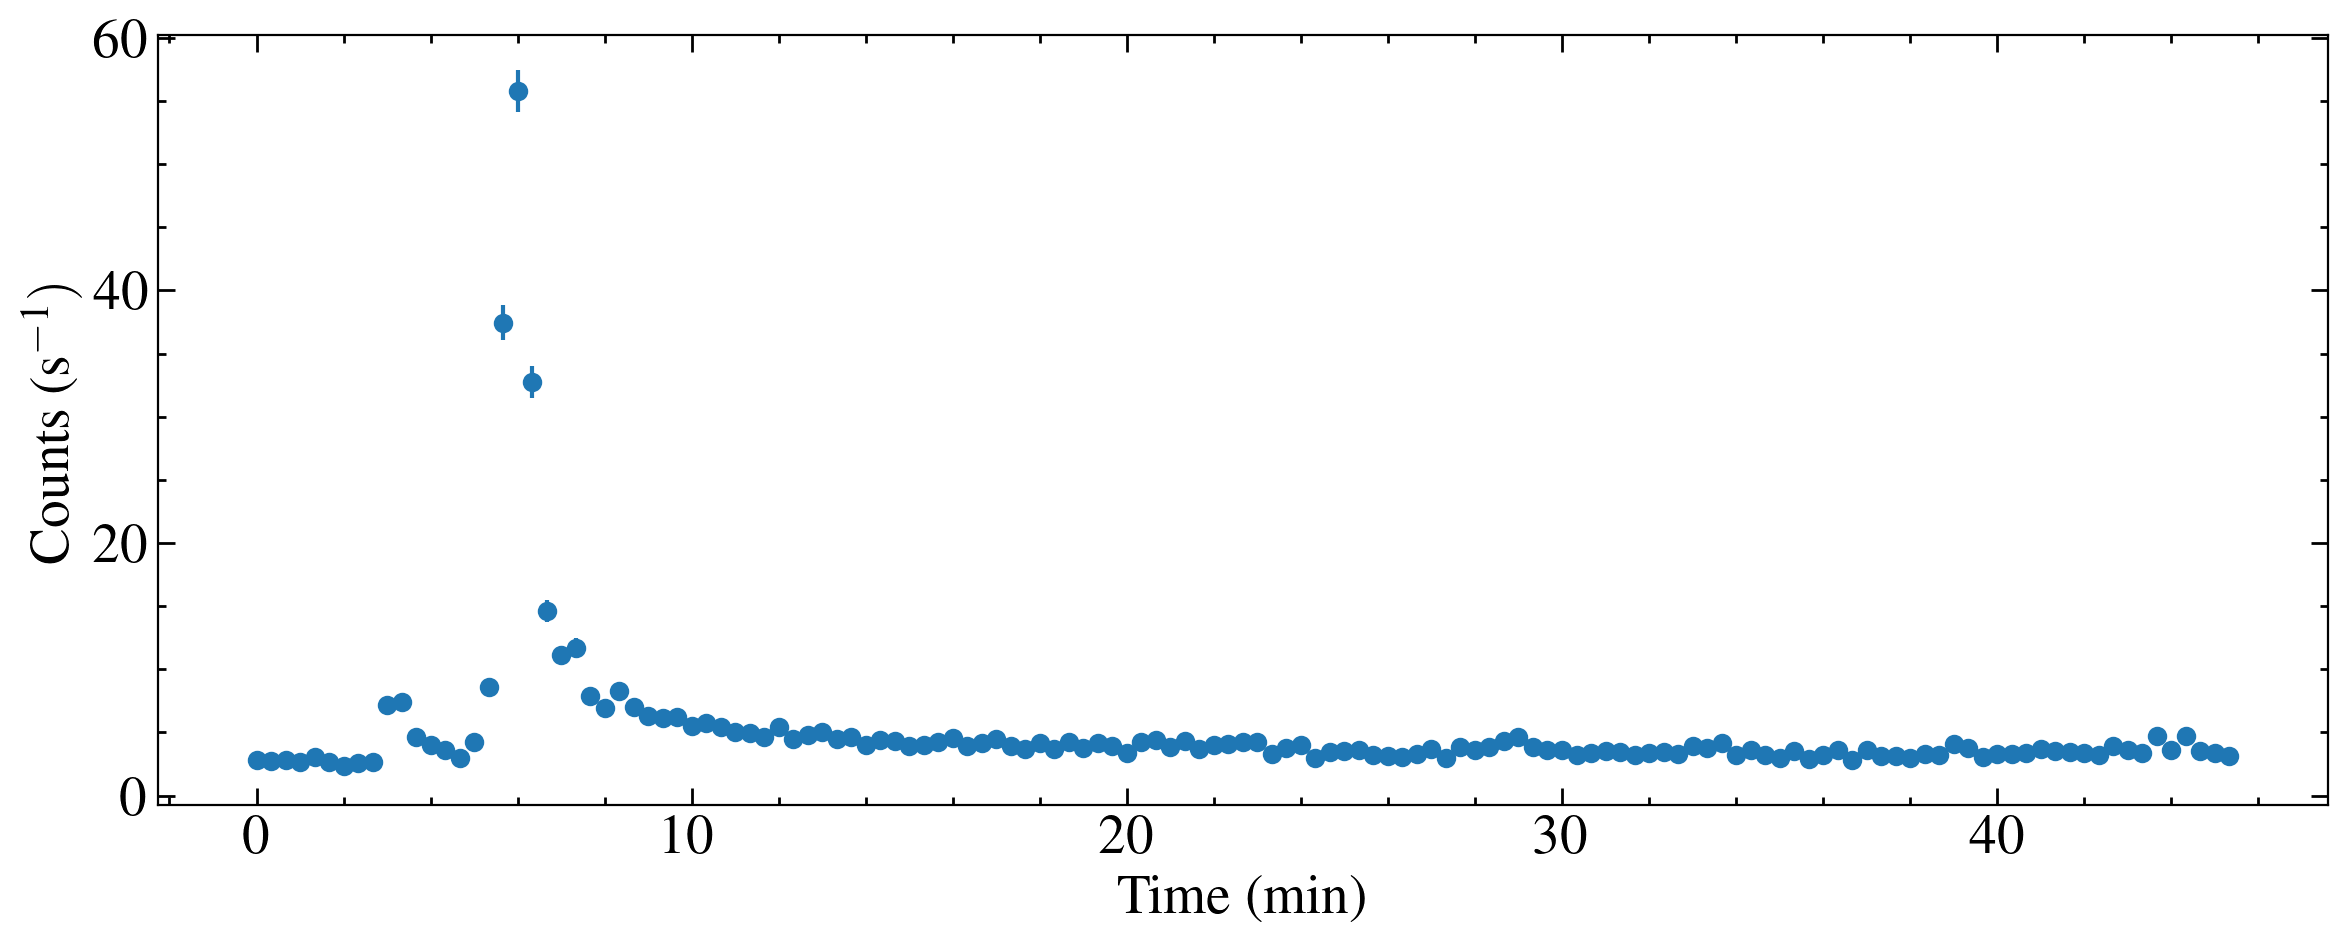

GJ674


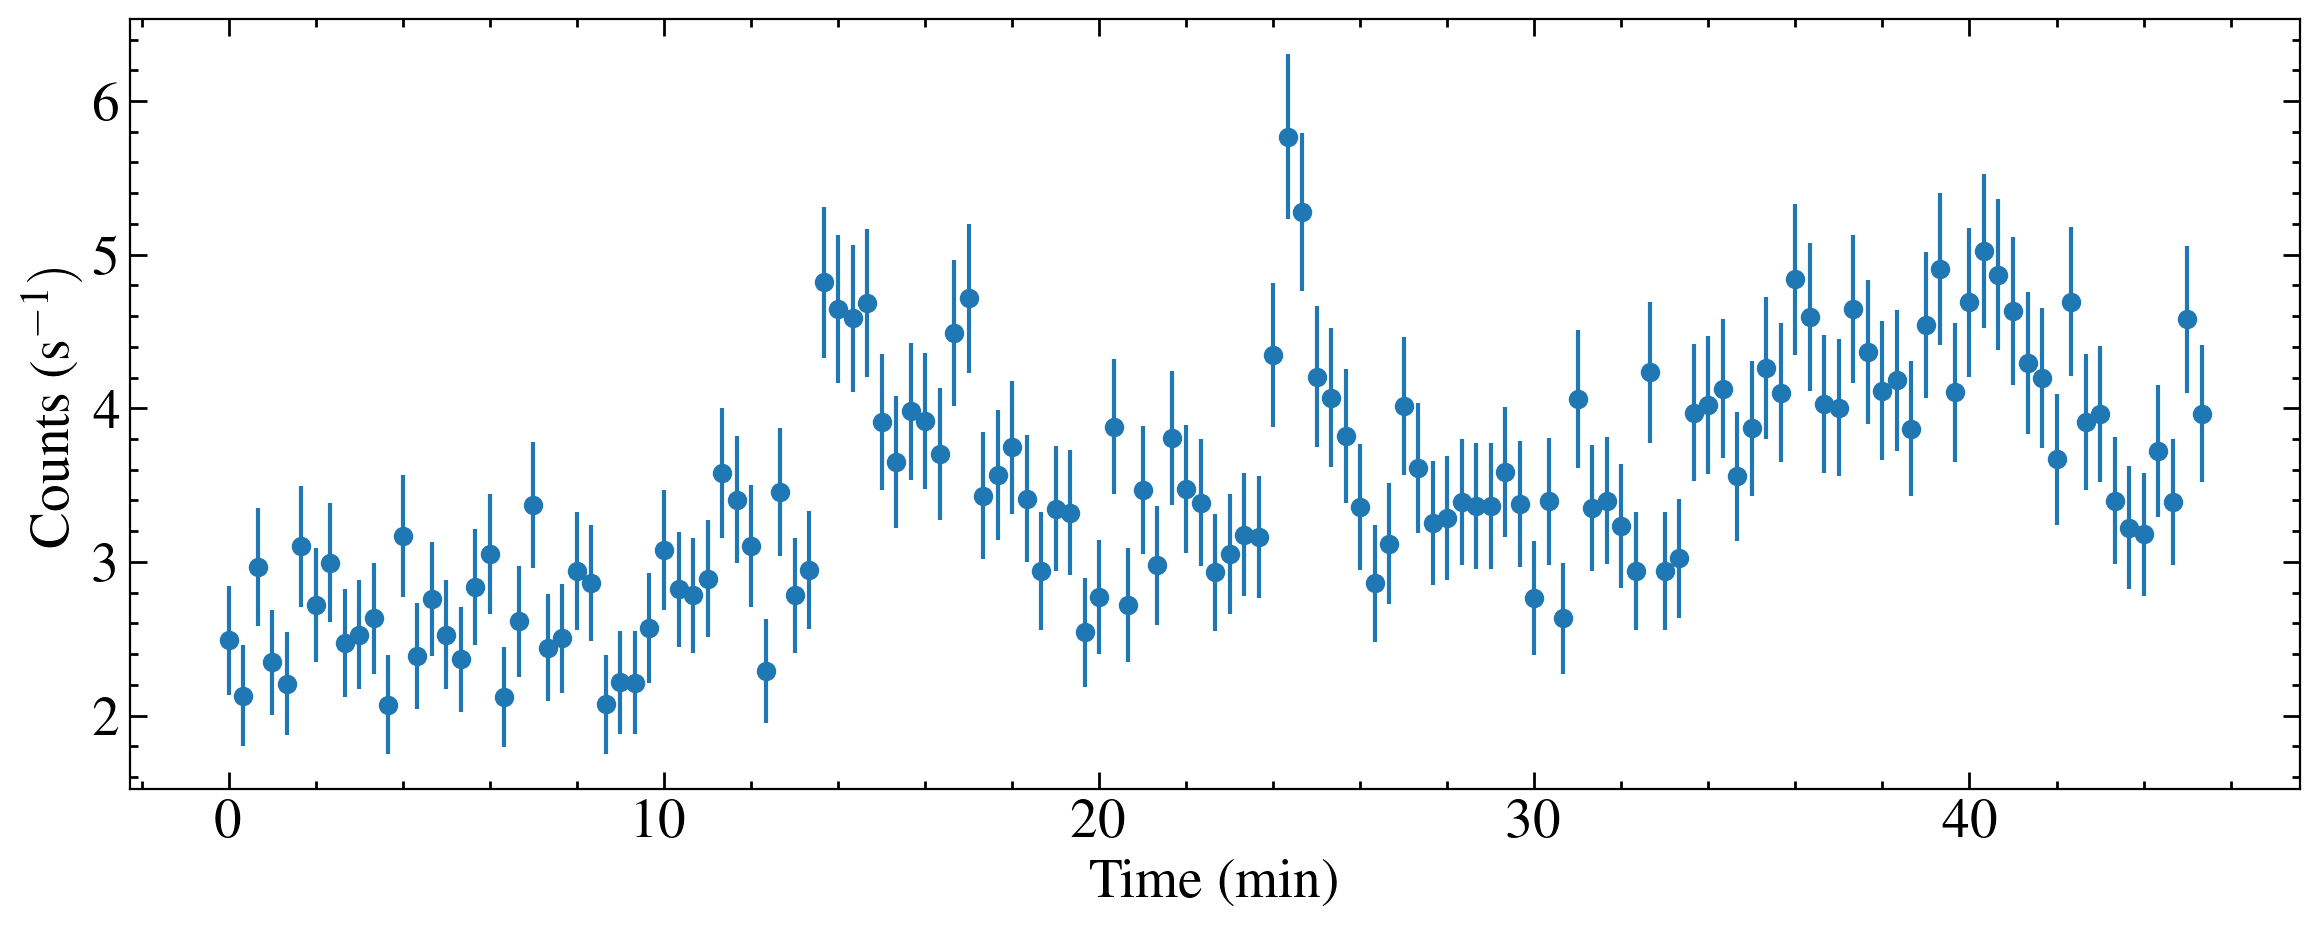

GJ699


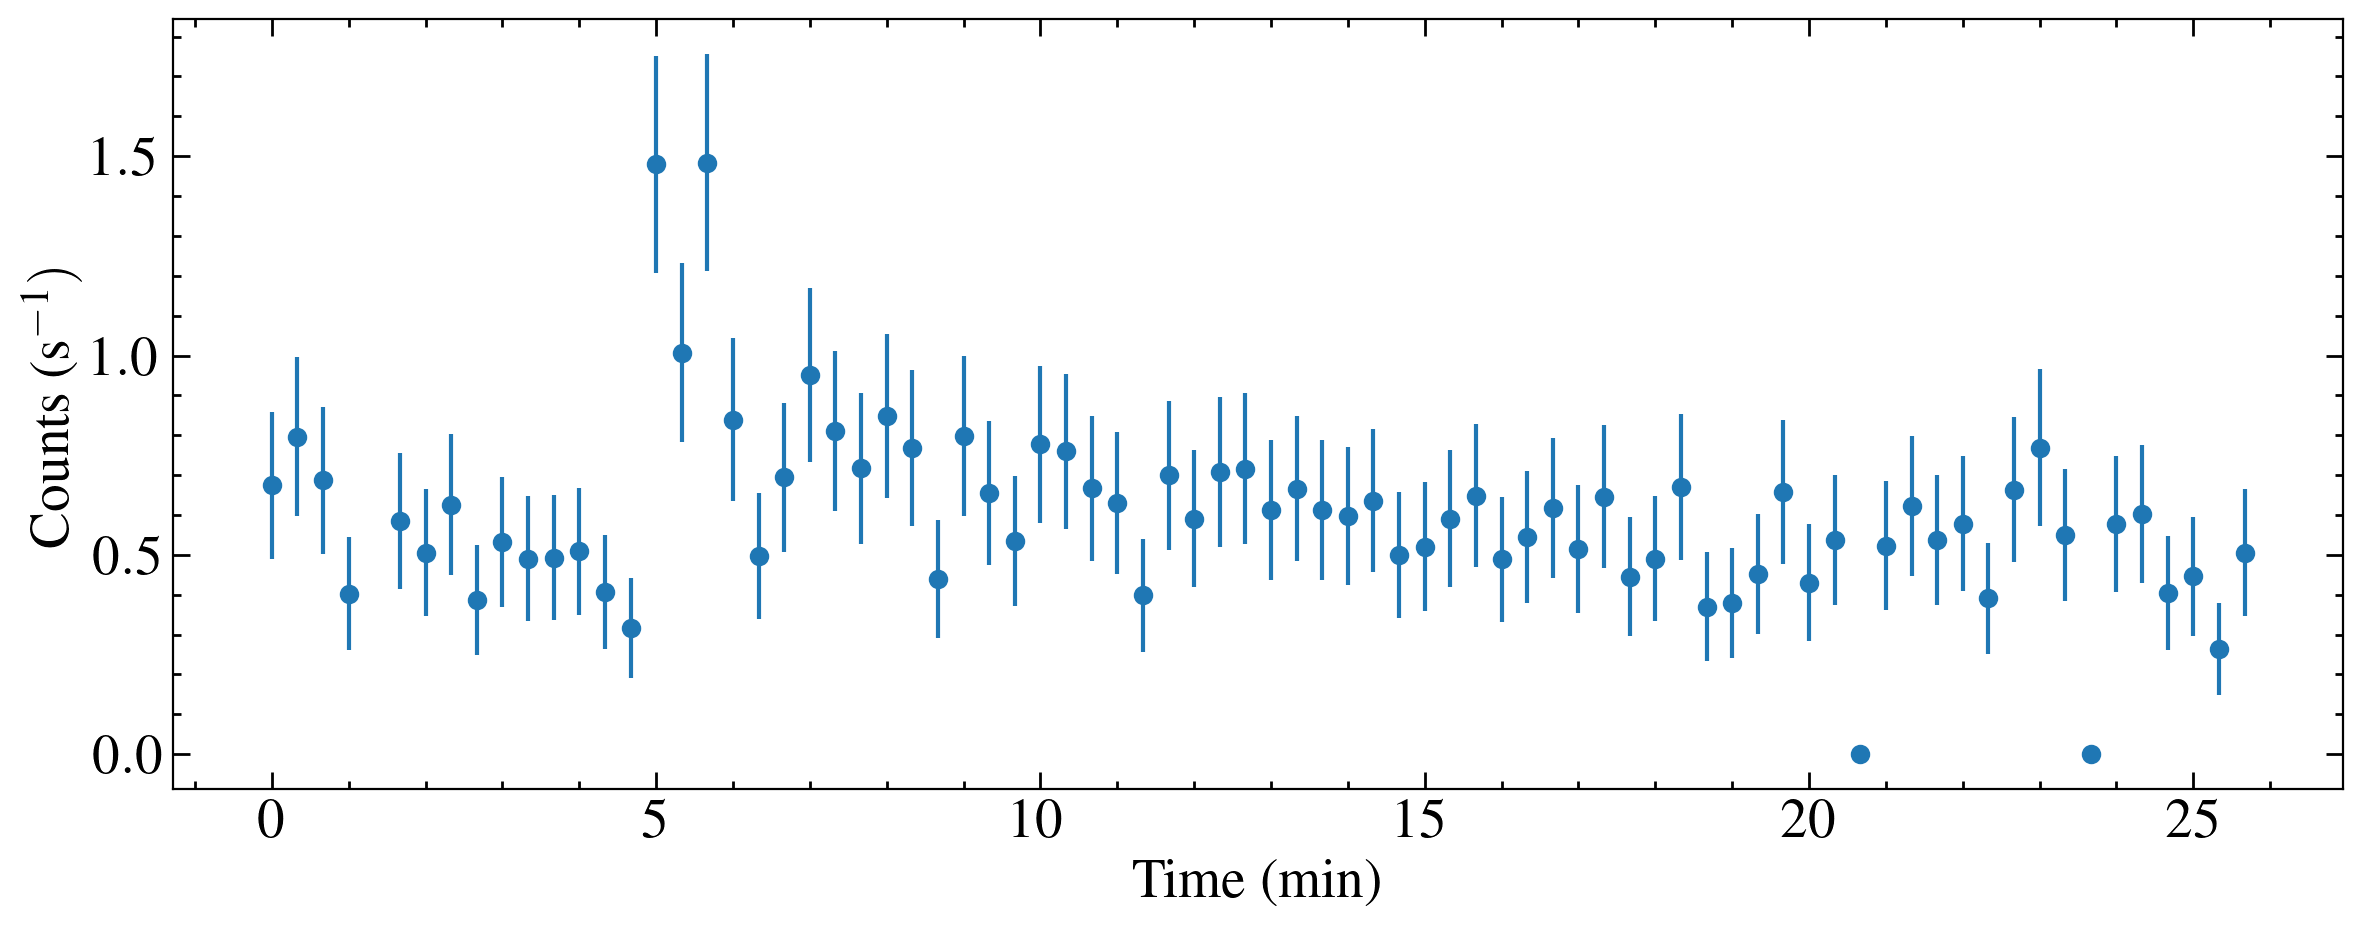

GJ699


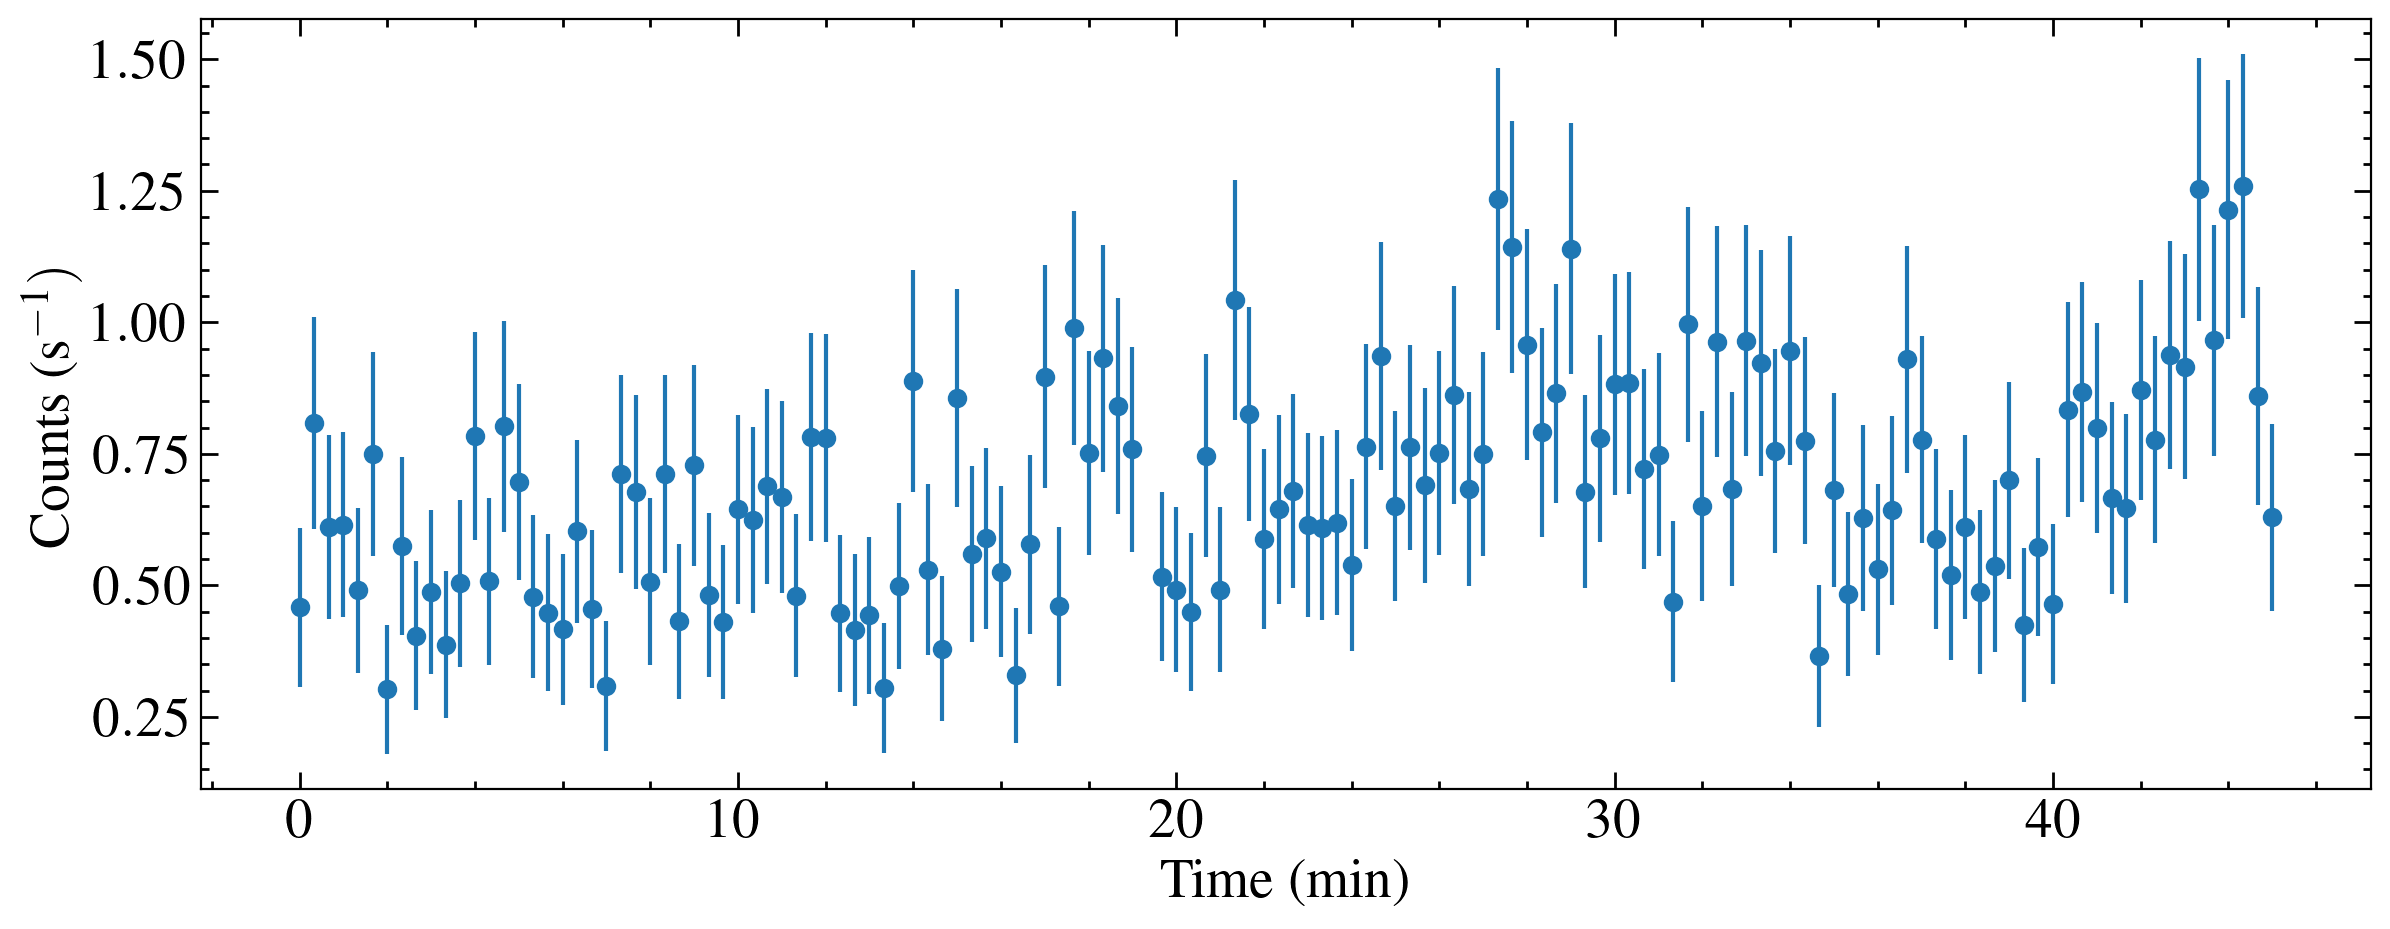

GJ699


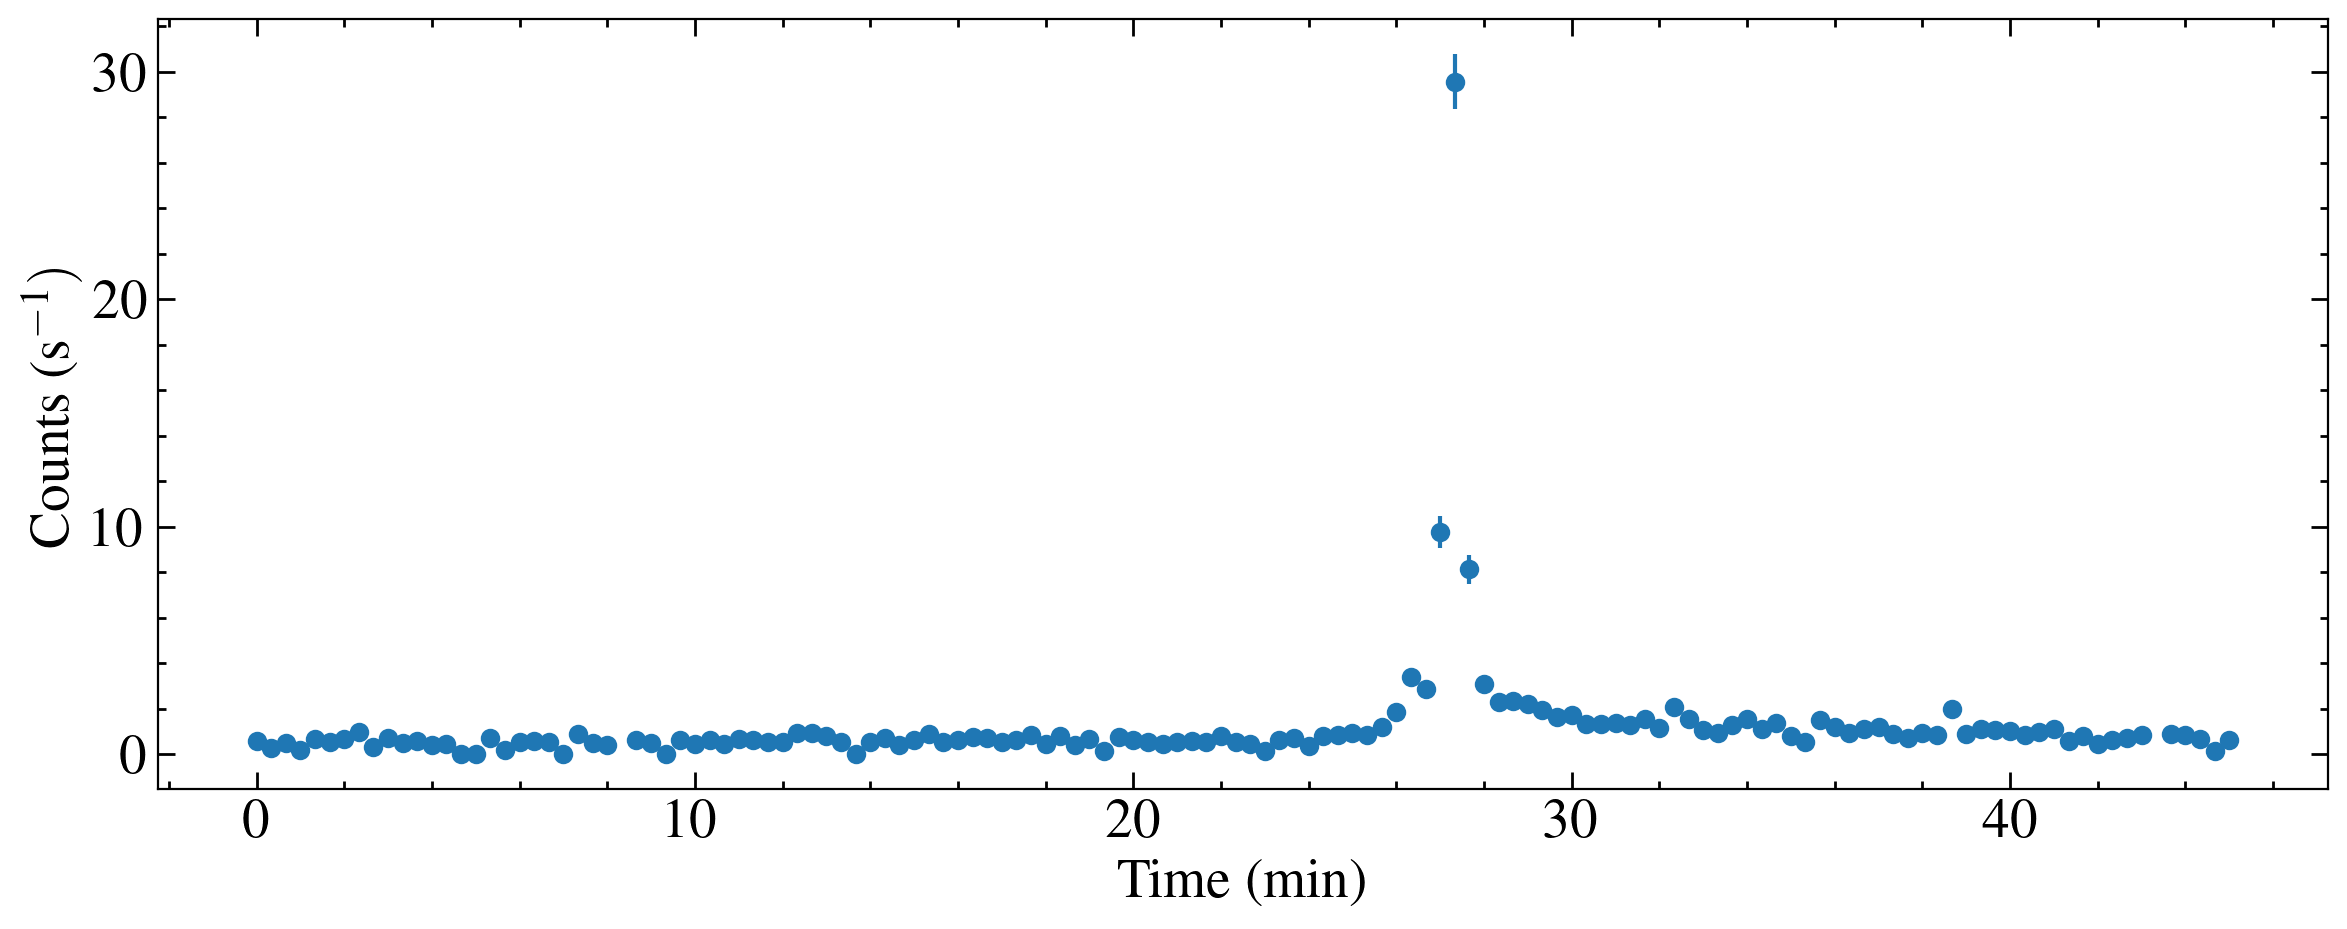

LHS-2686


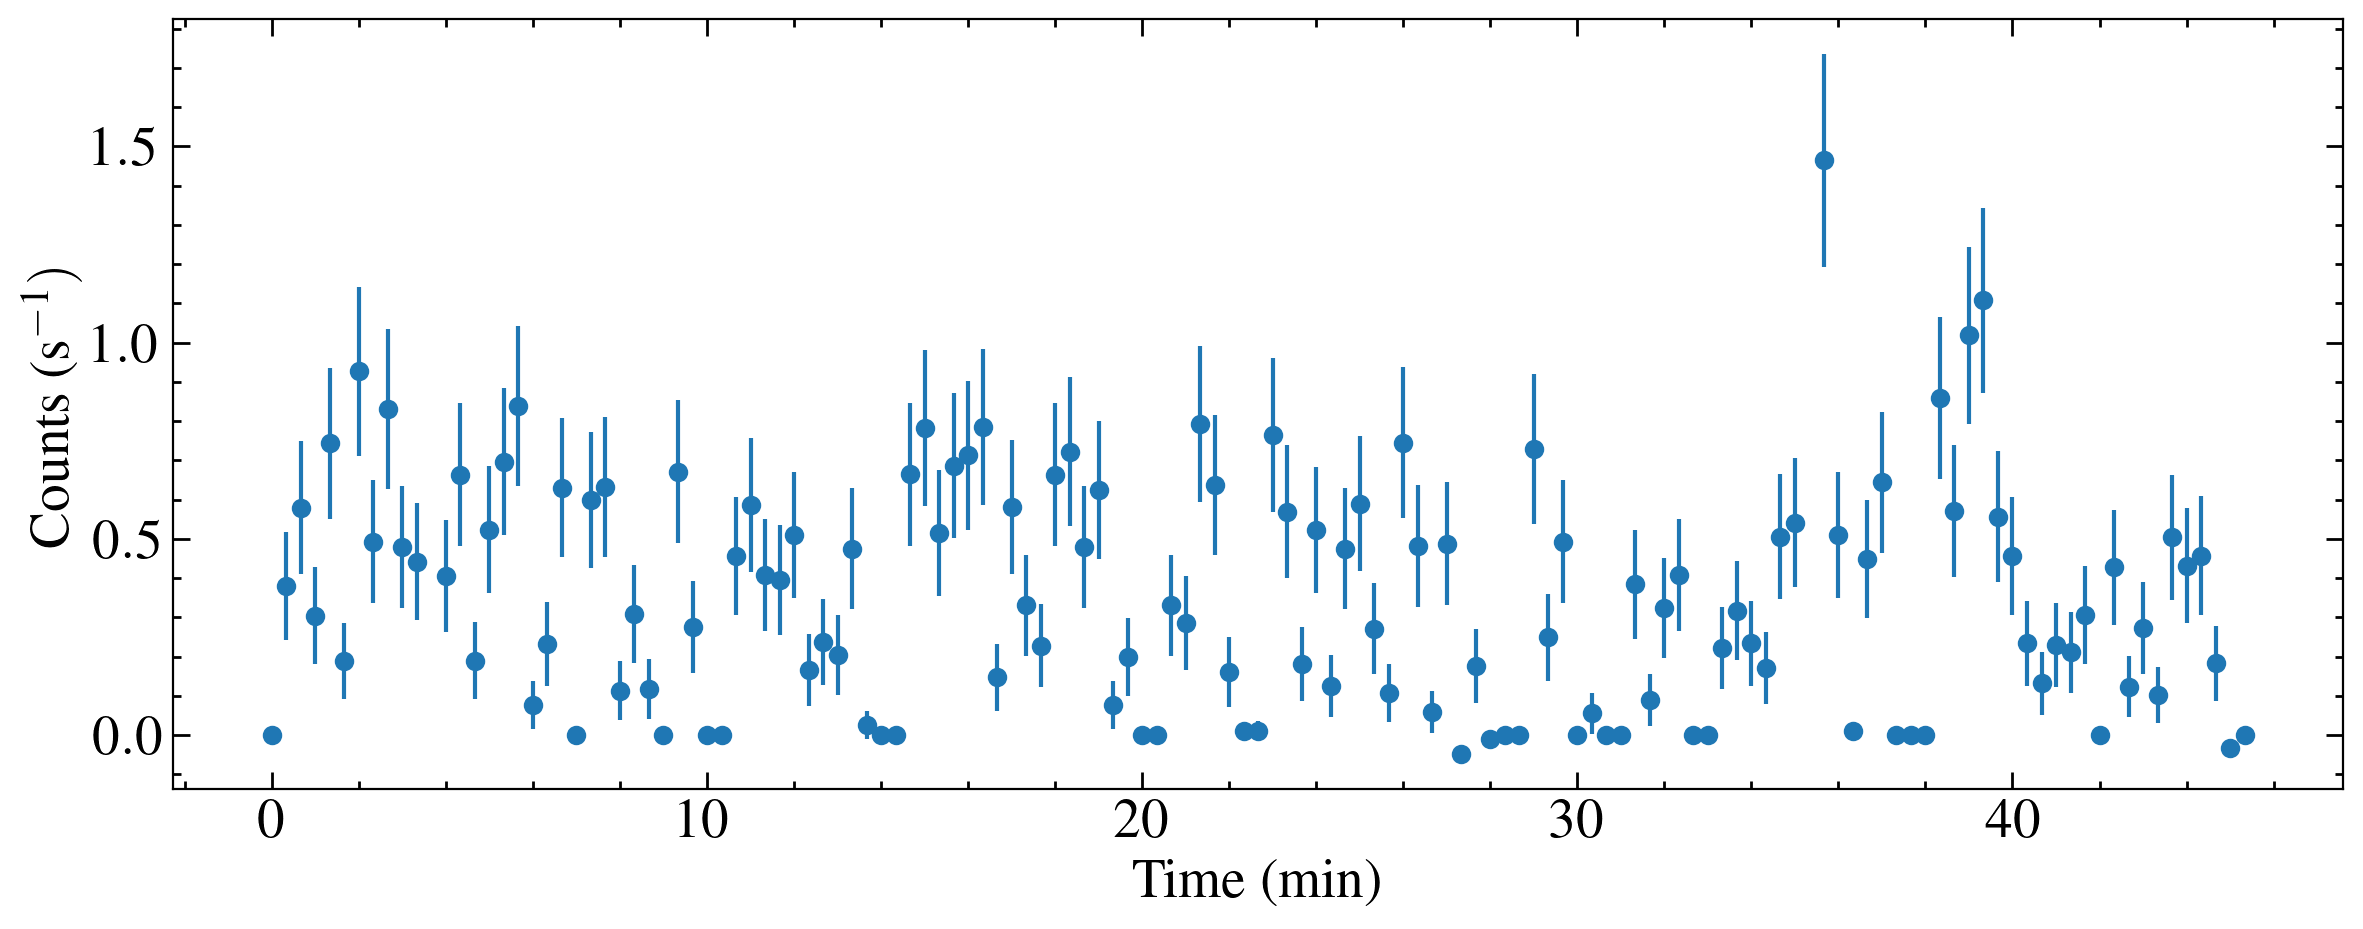

LHS-2686


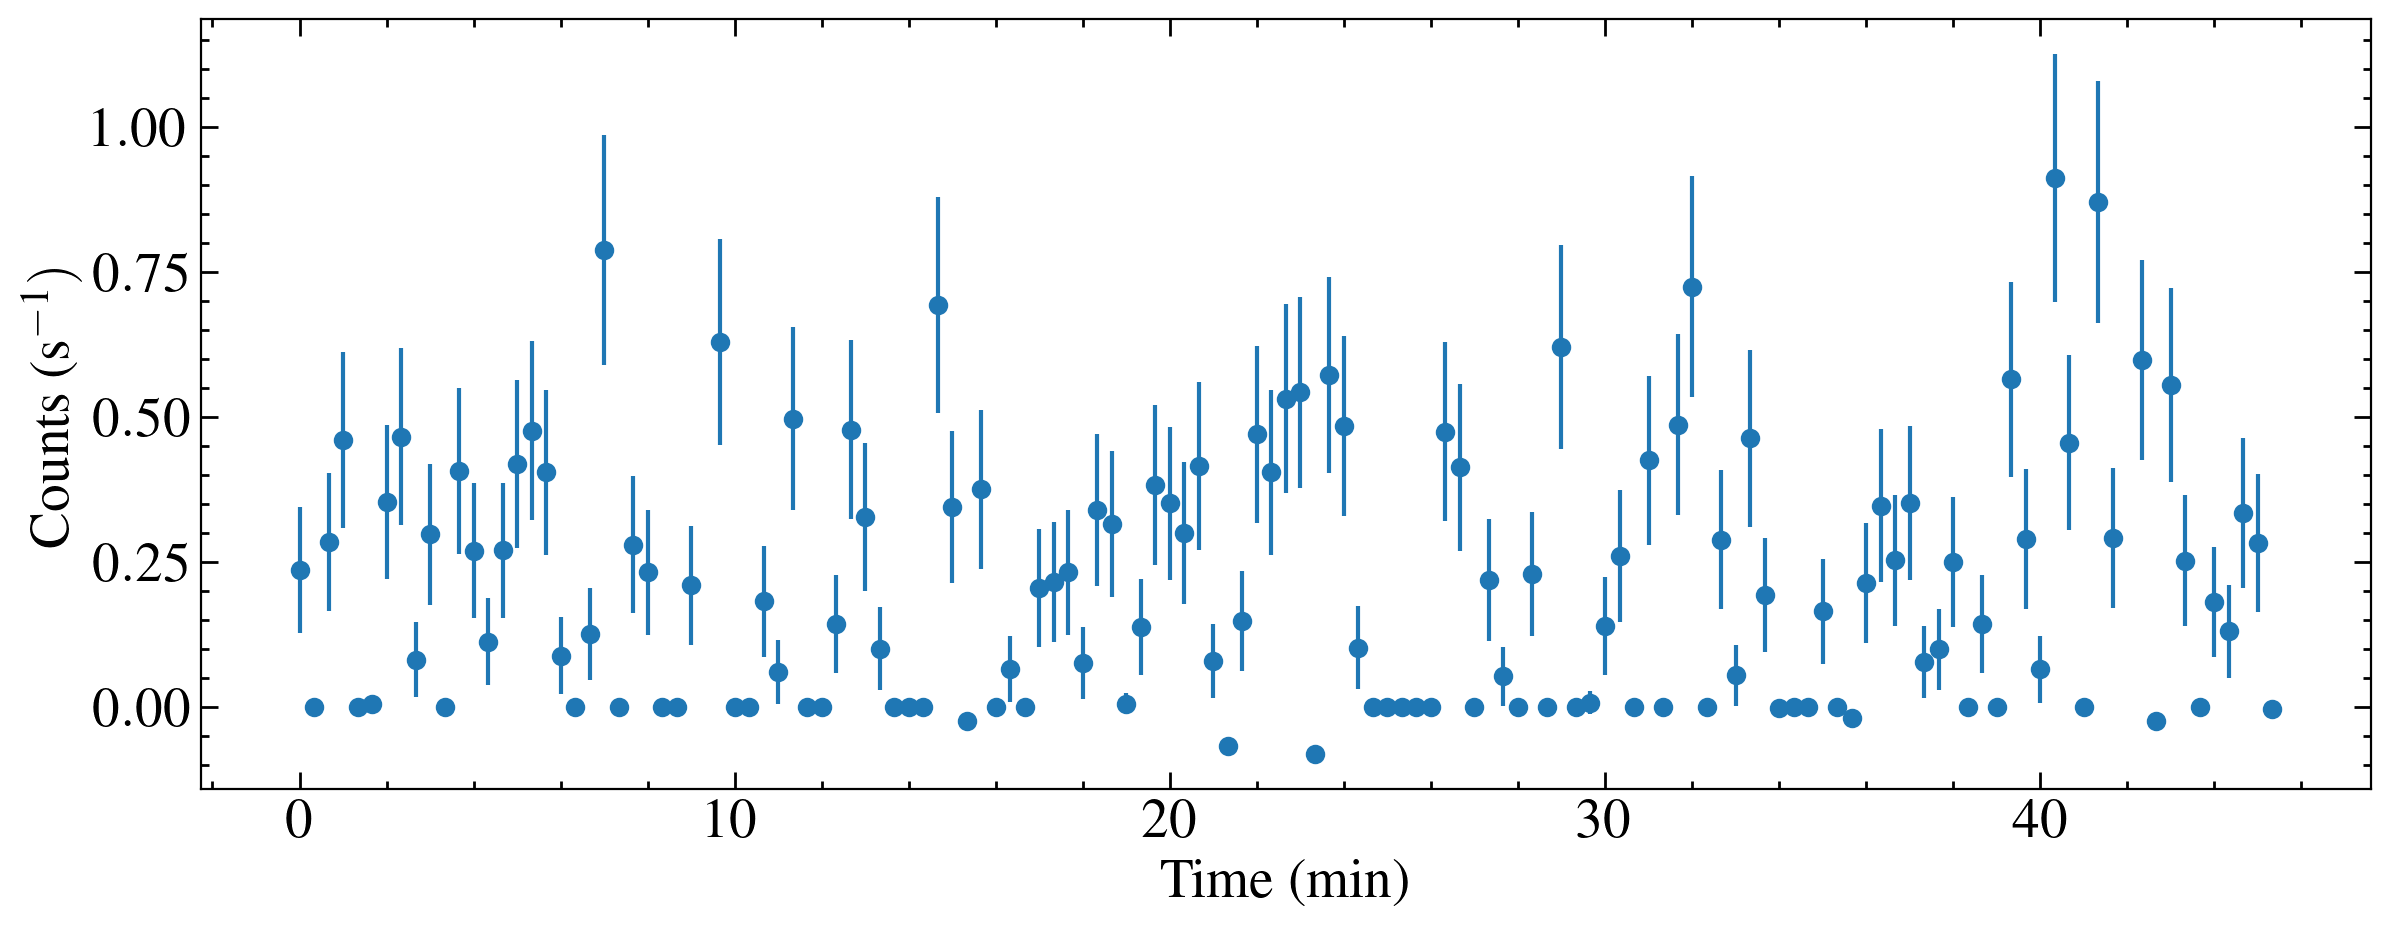

LHS-2686


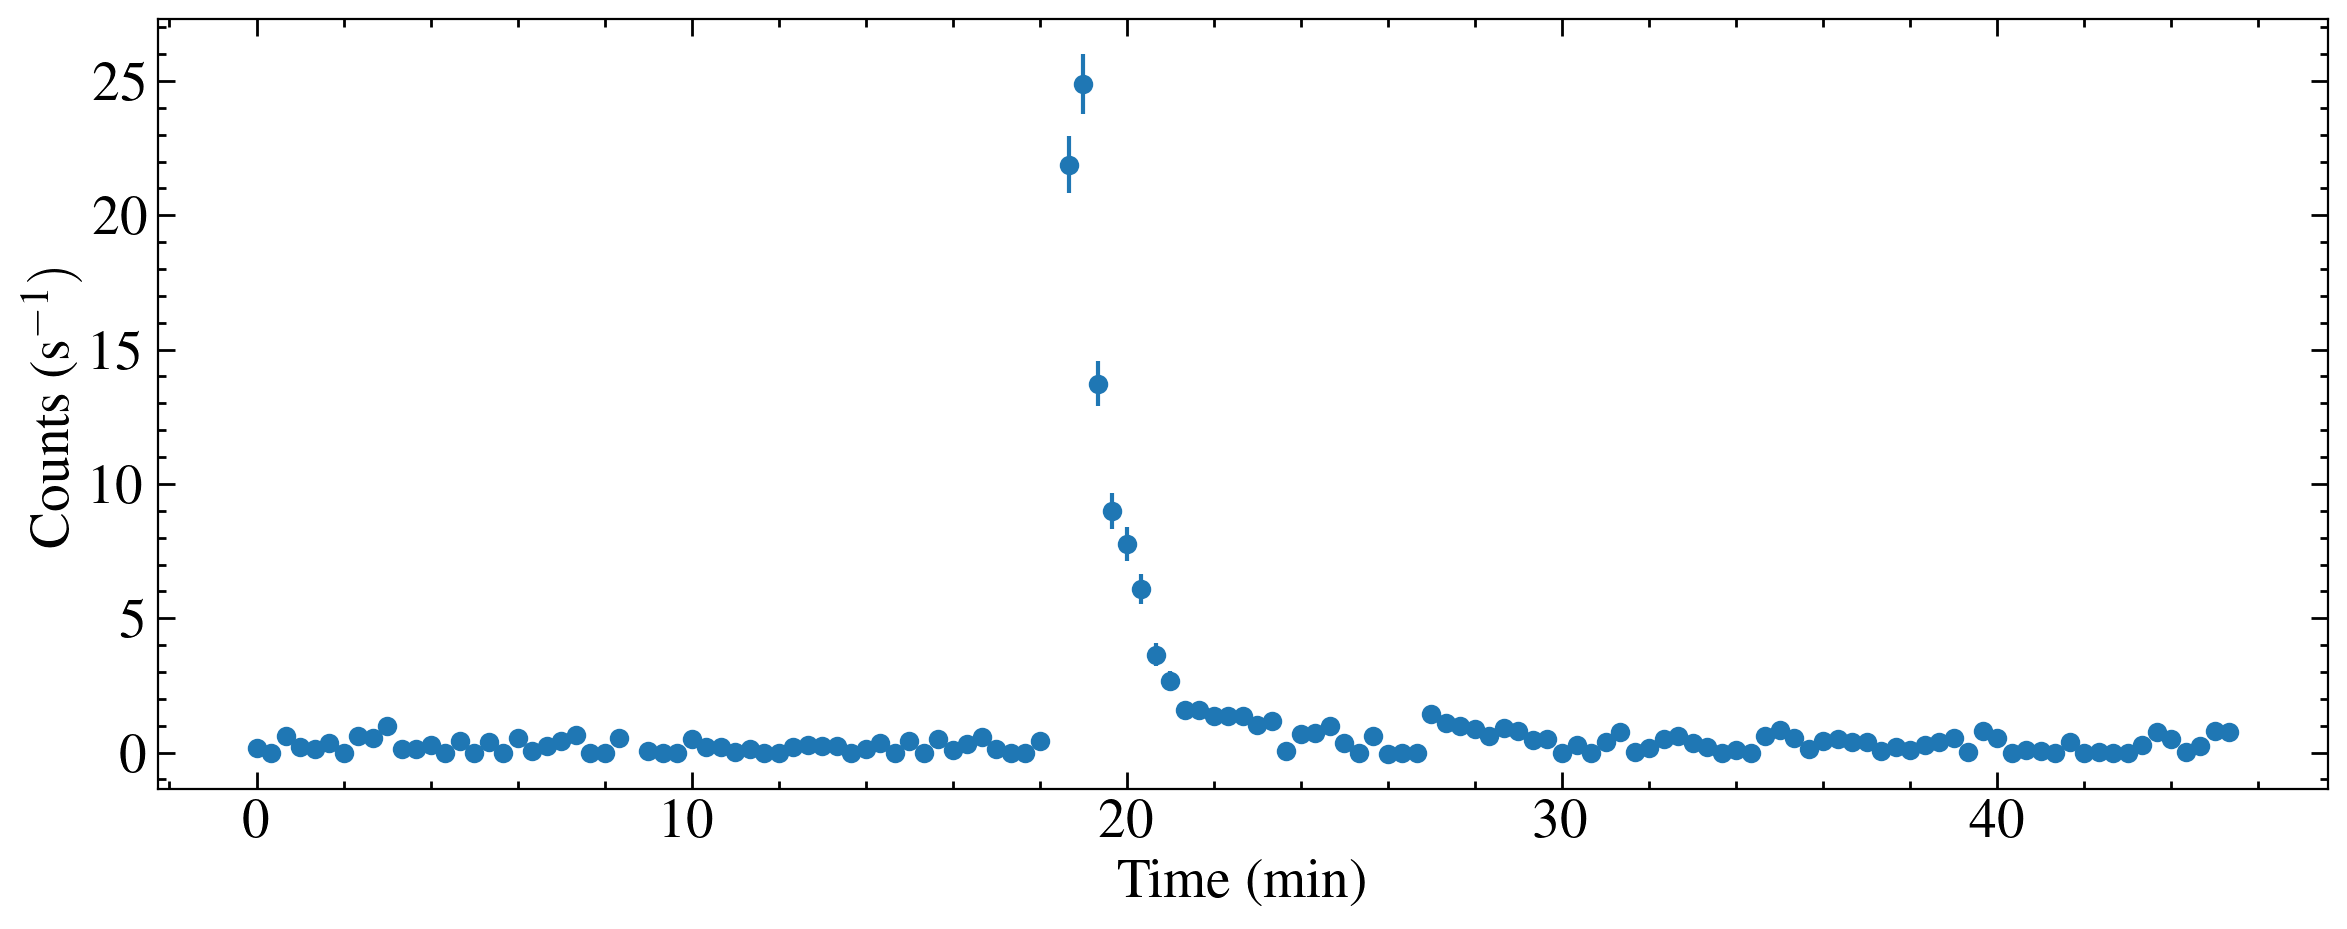

LHS-2686


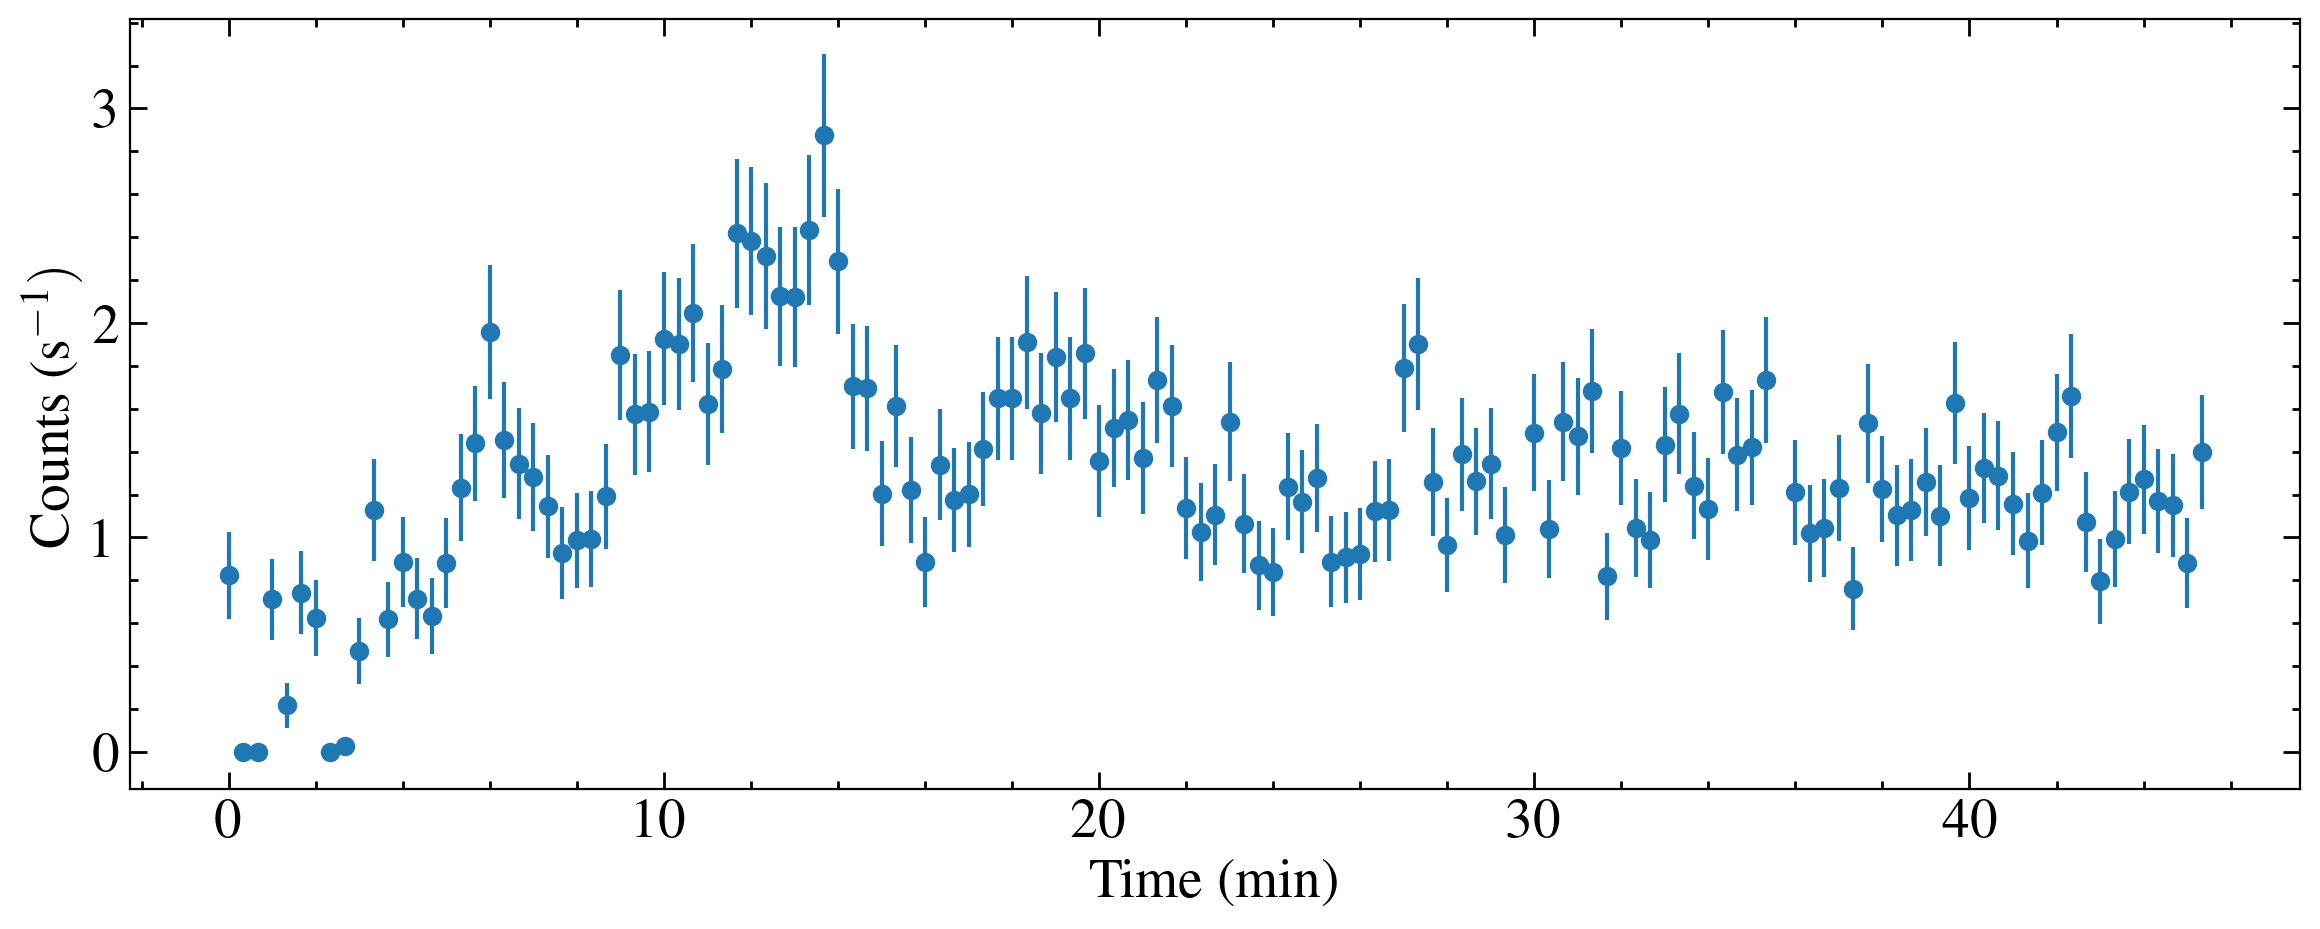

GJ676A


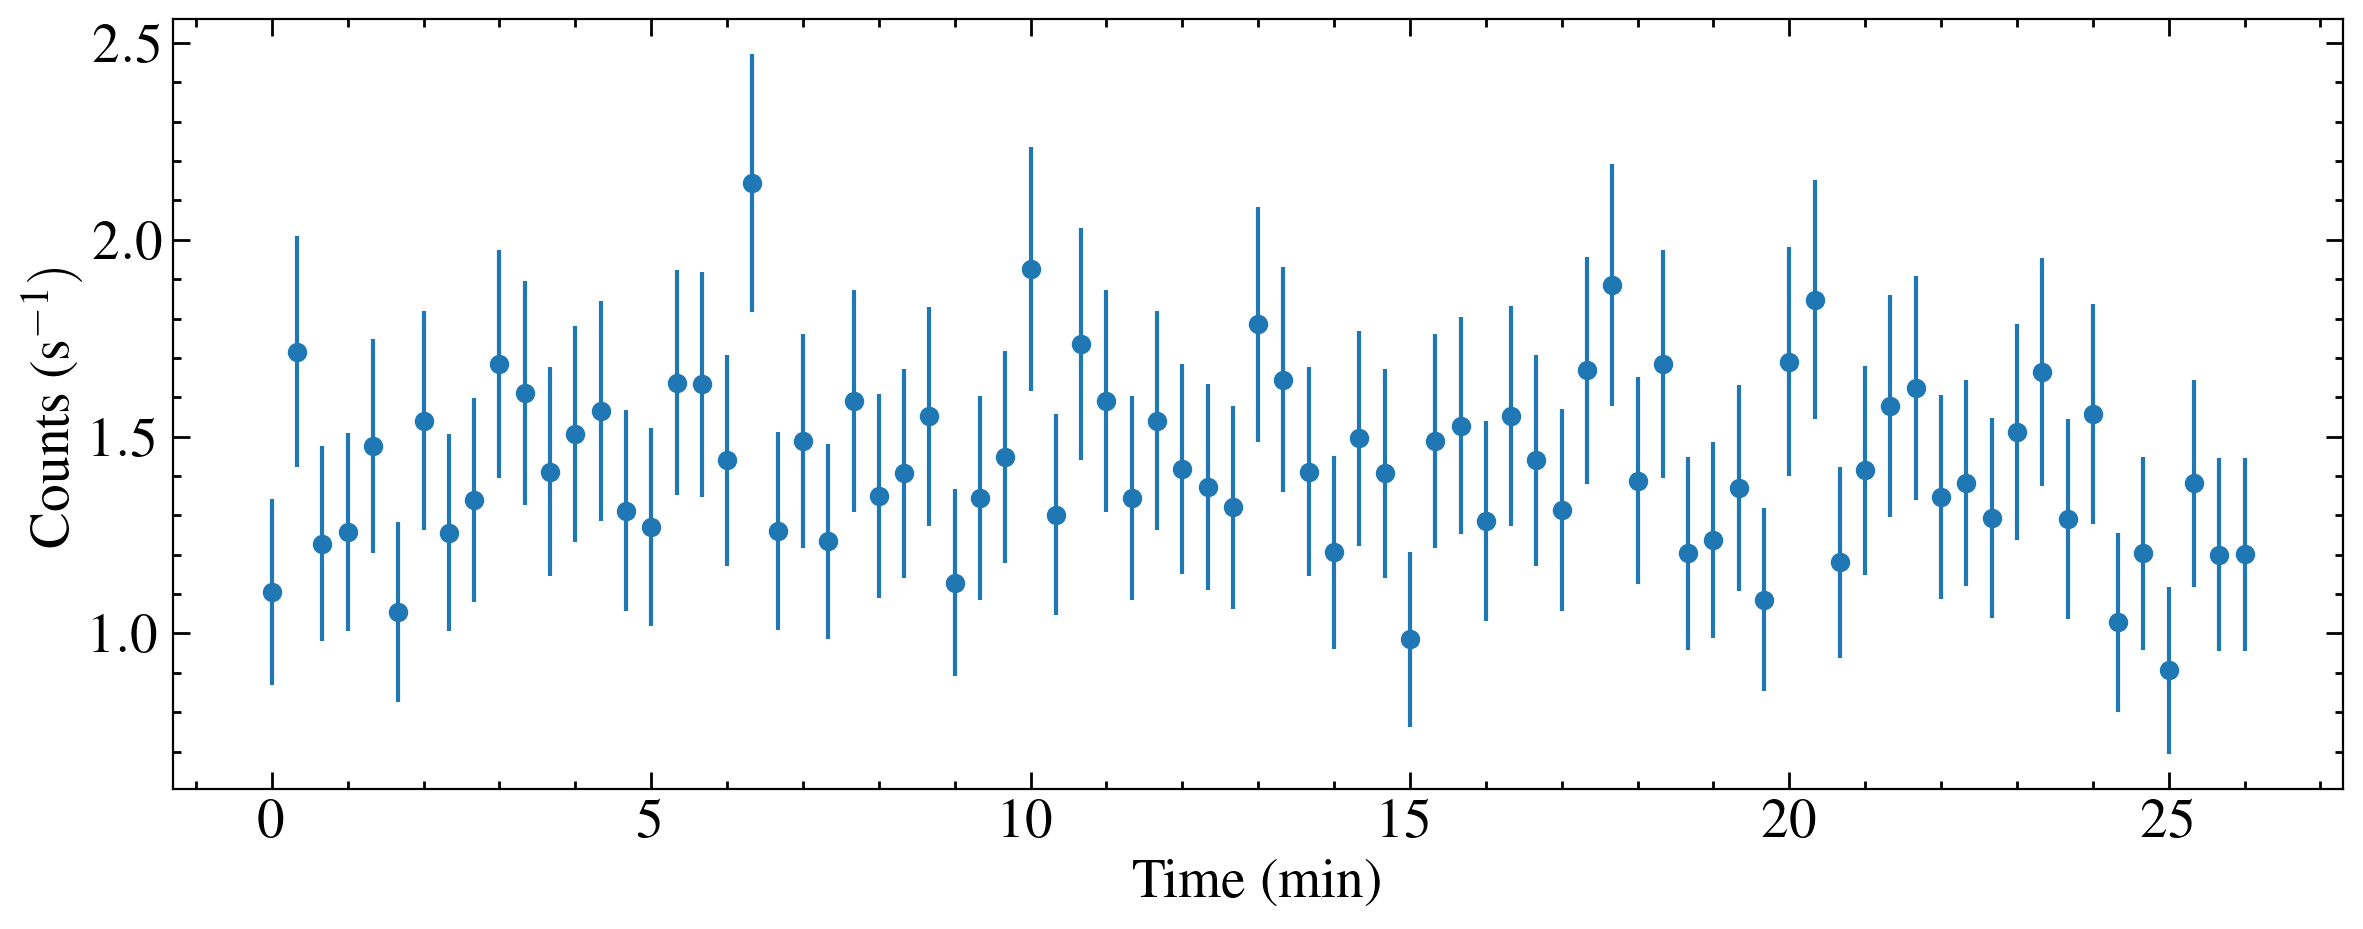

GJ676A


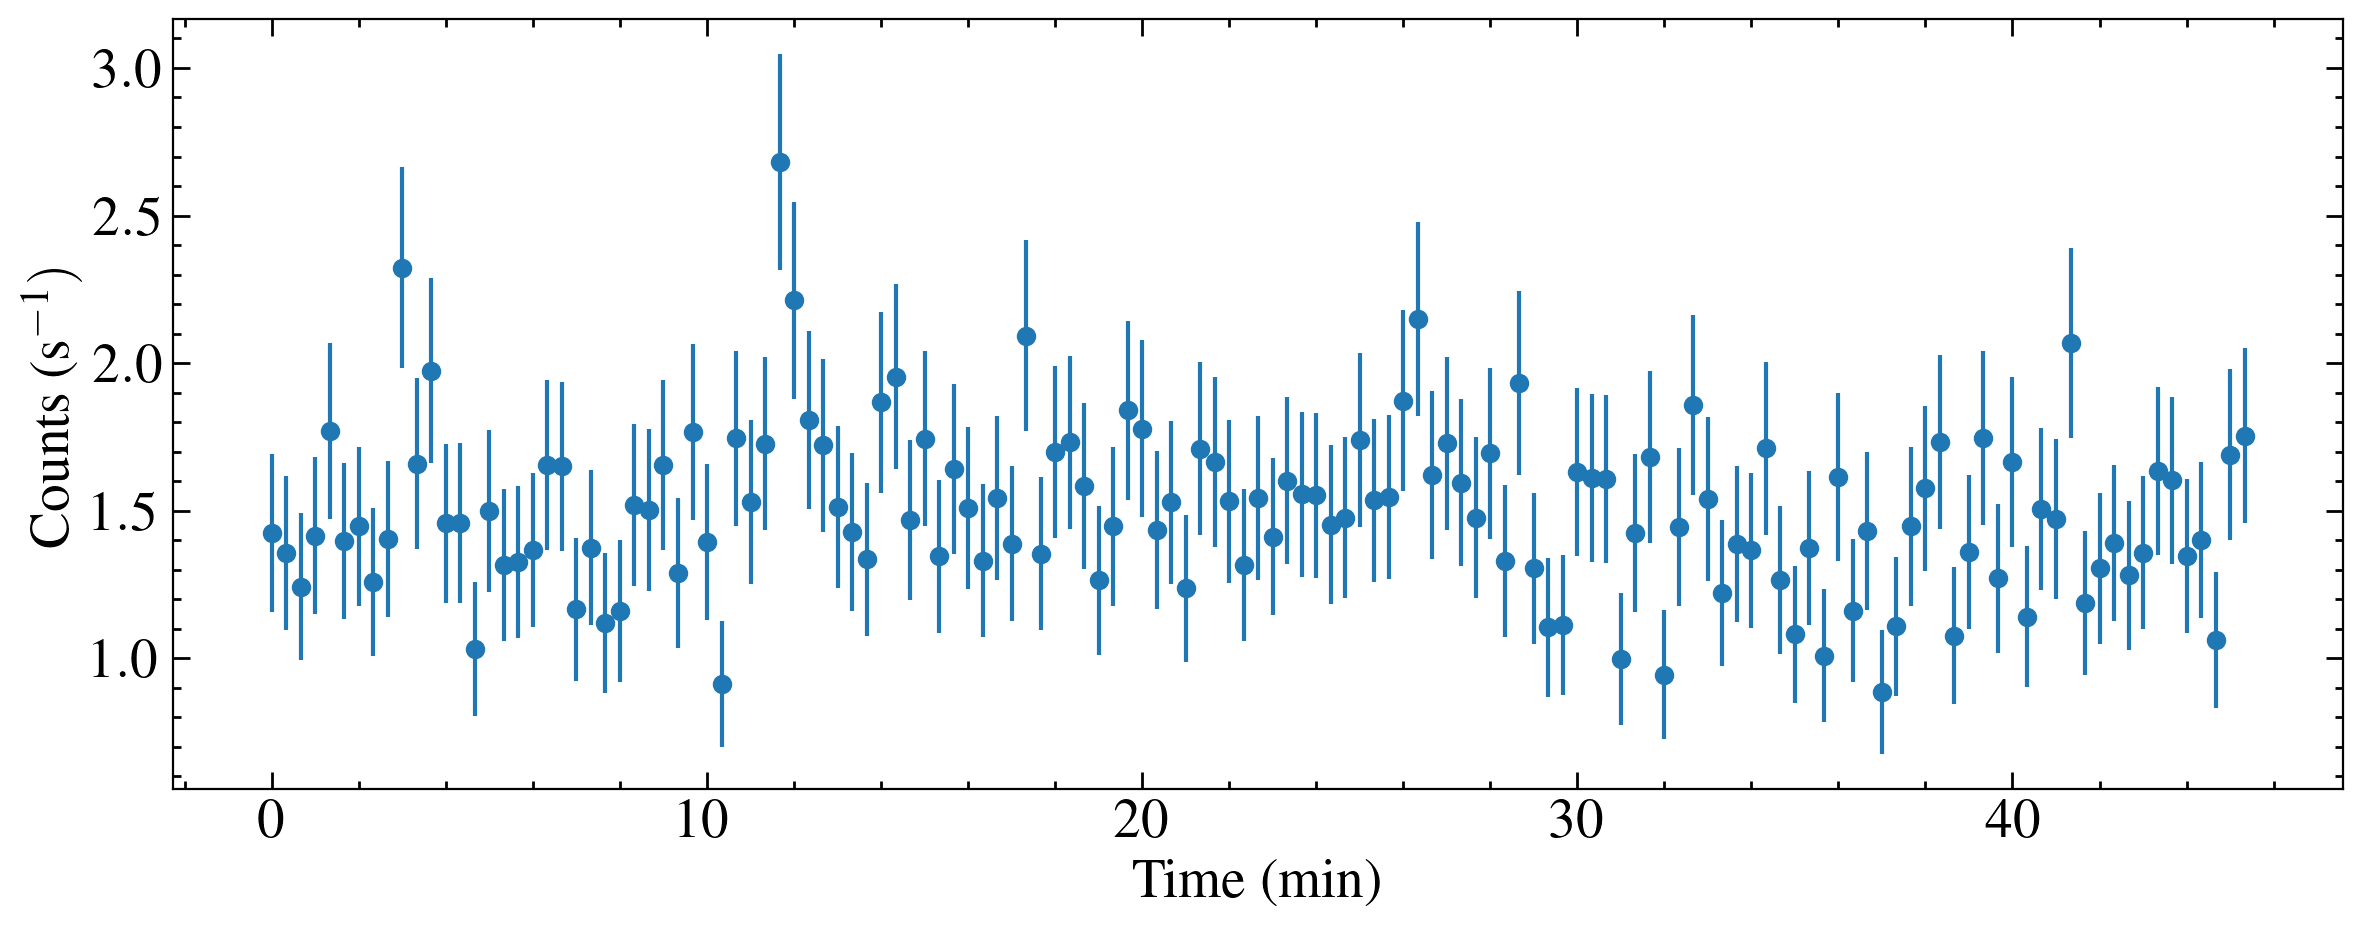

GJ676A


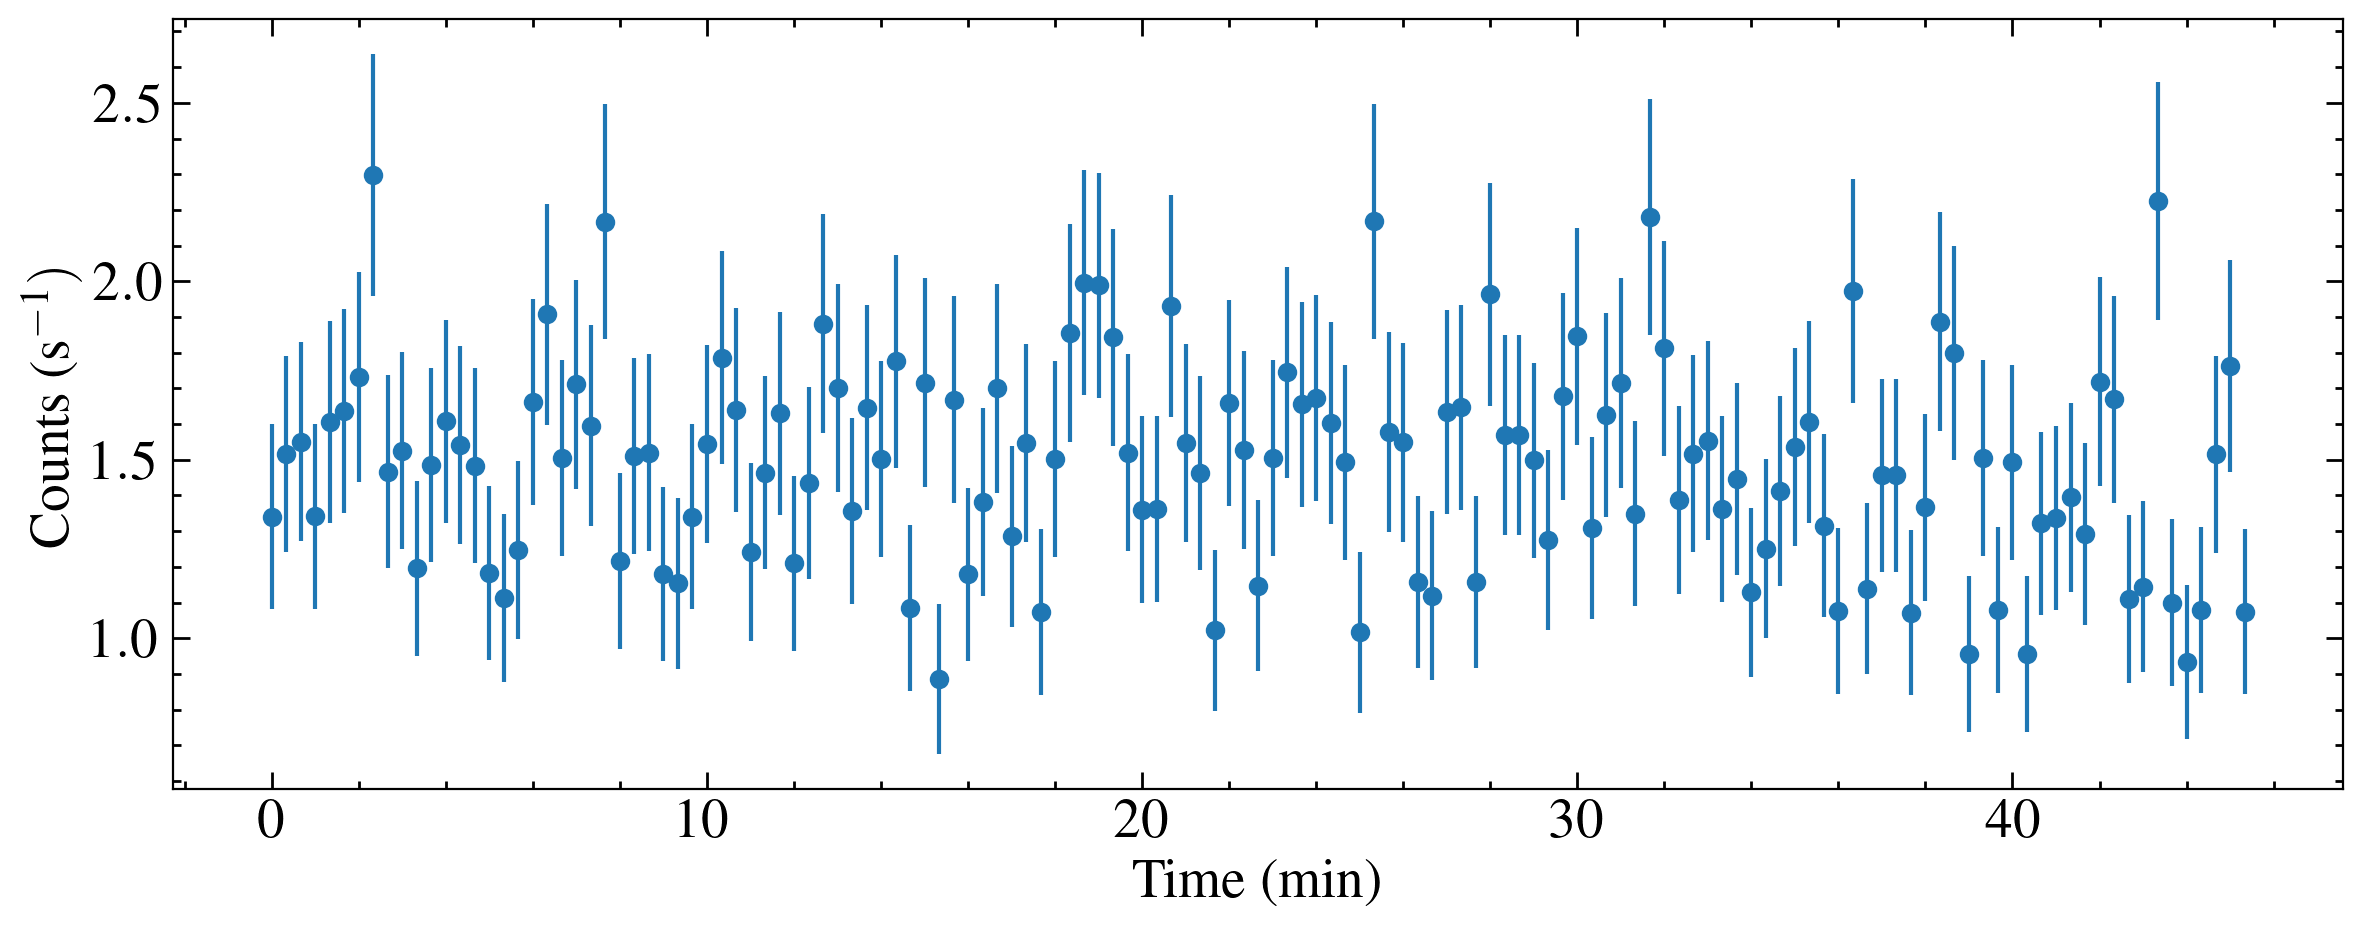

GJ676A


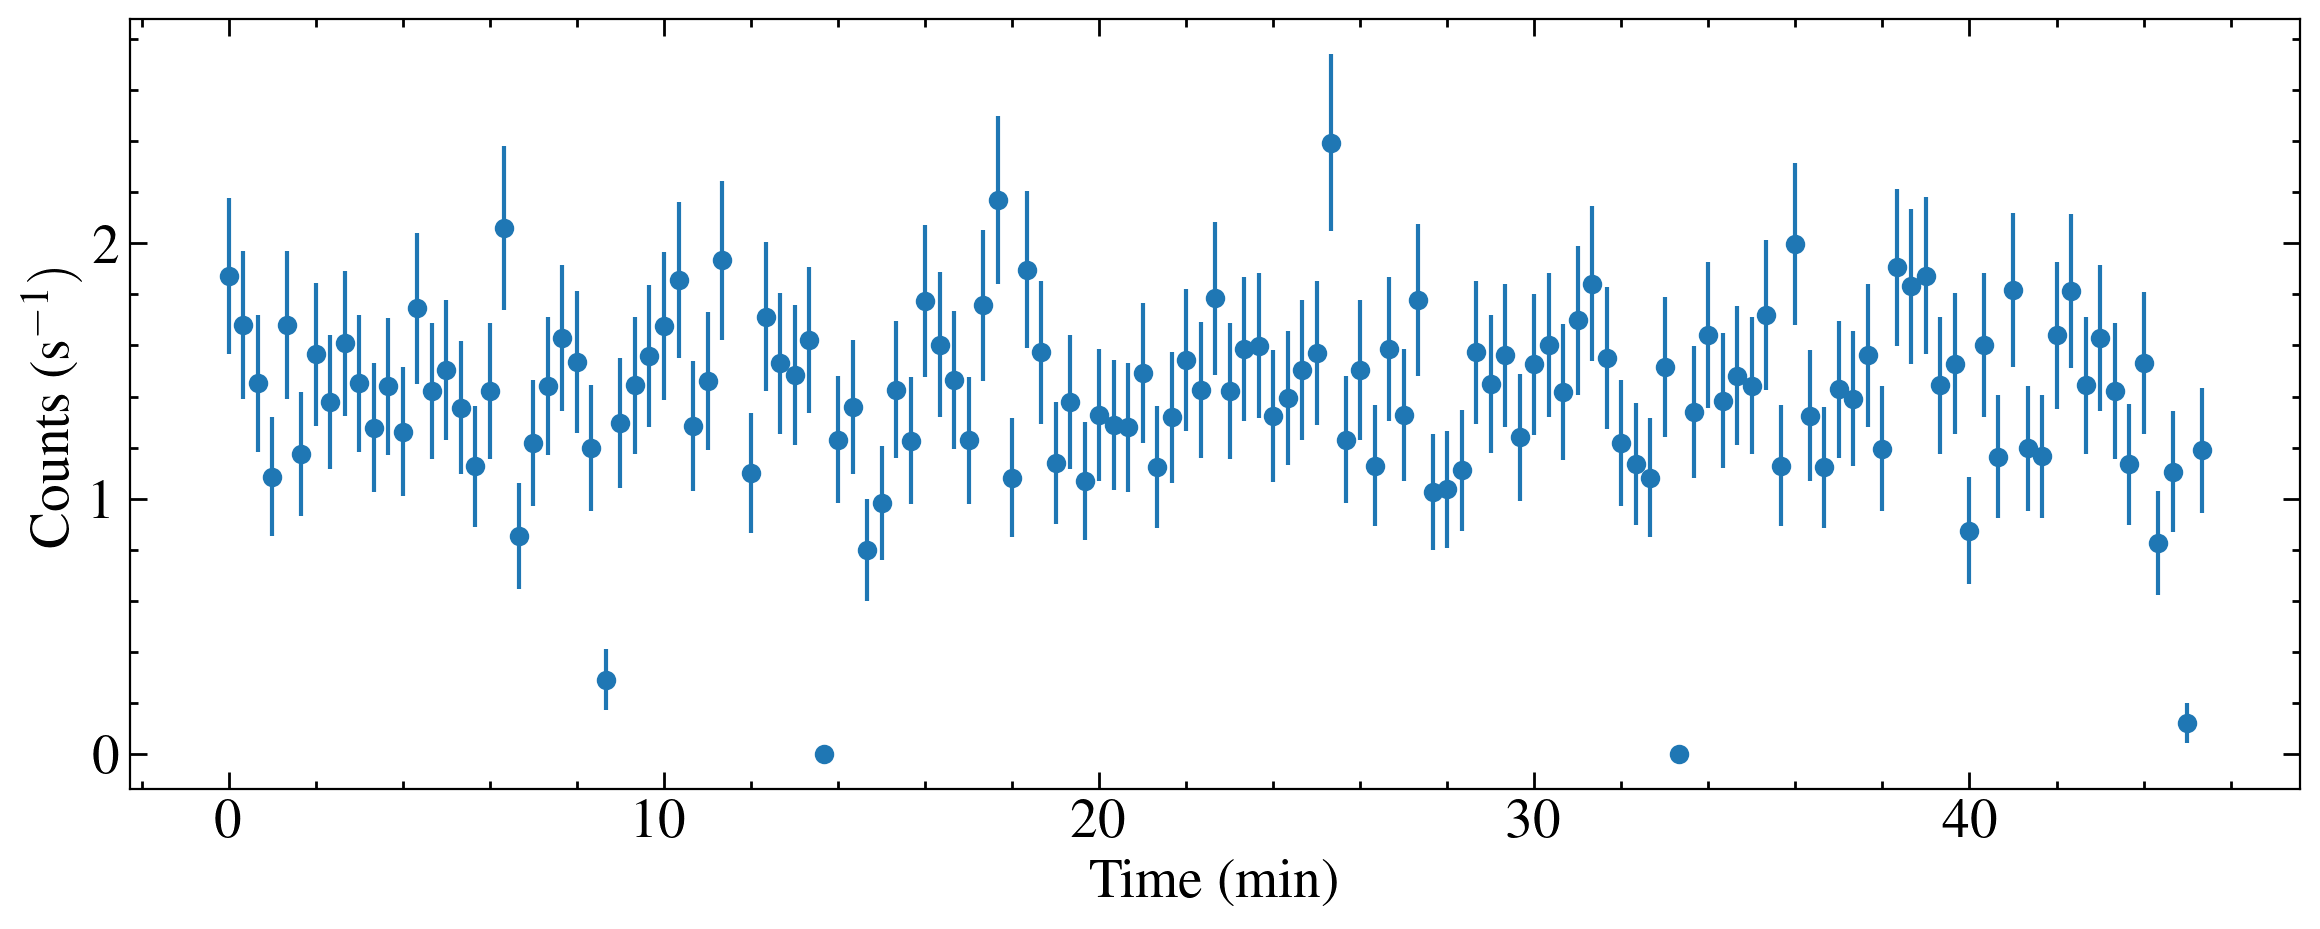

GJ676A


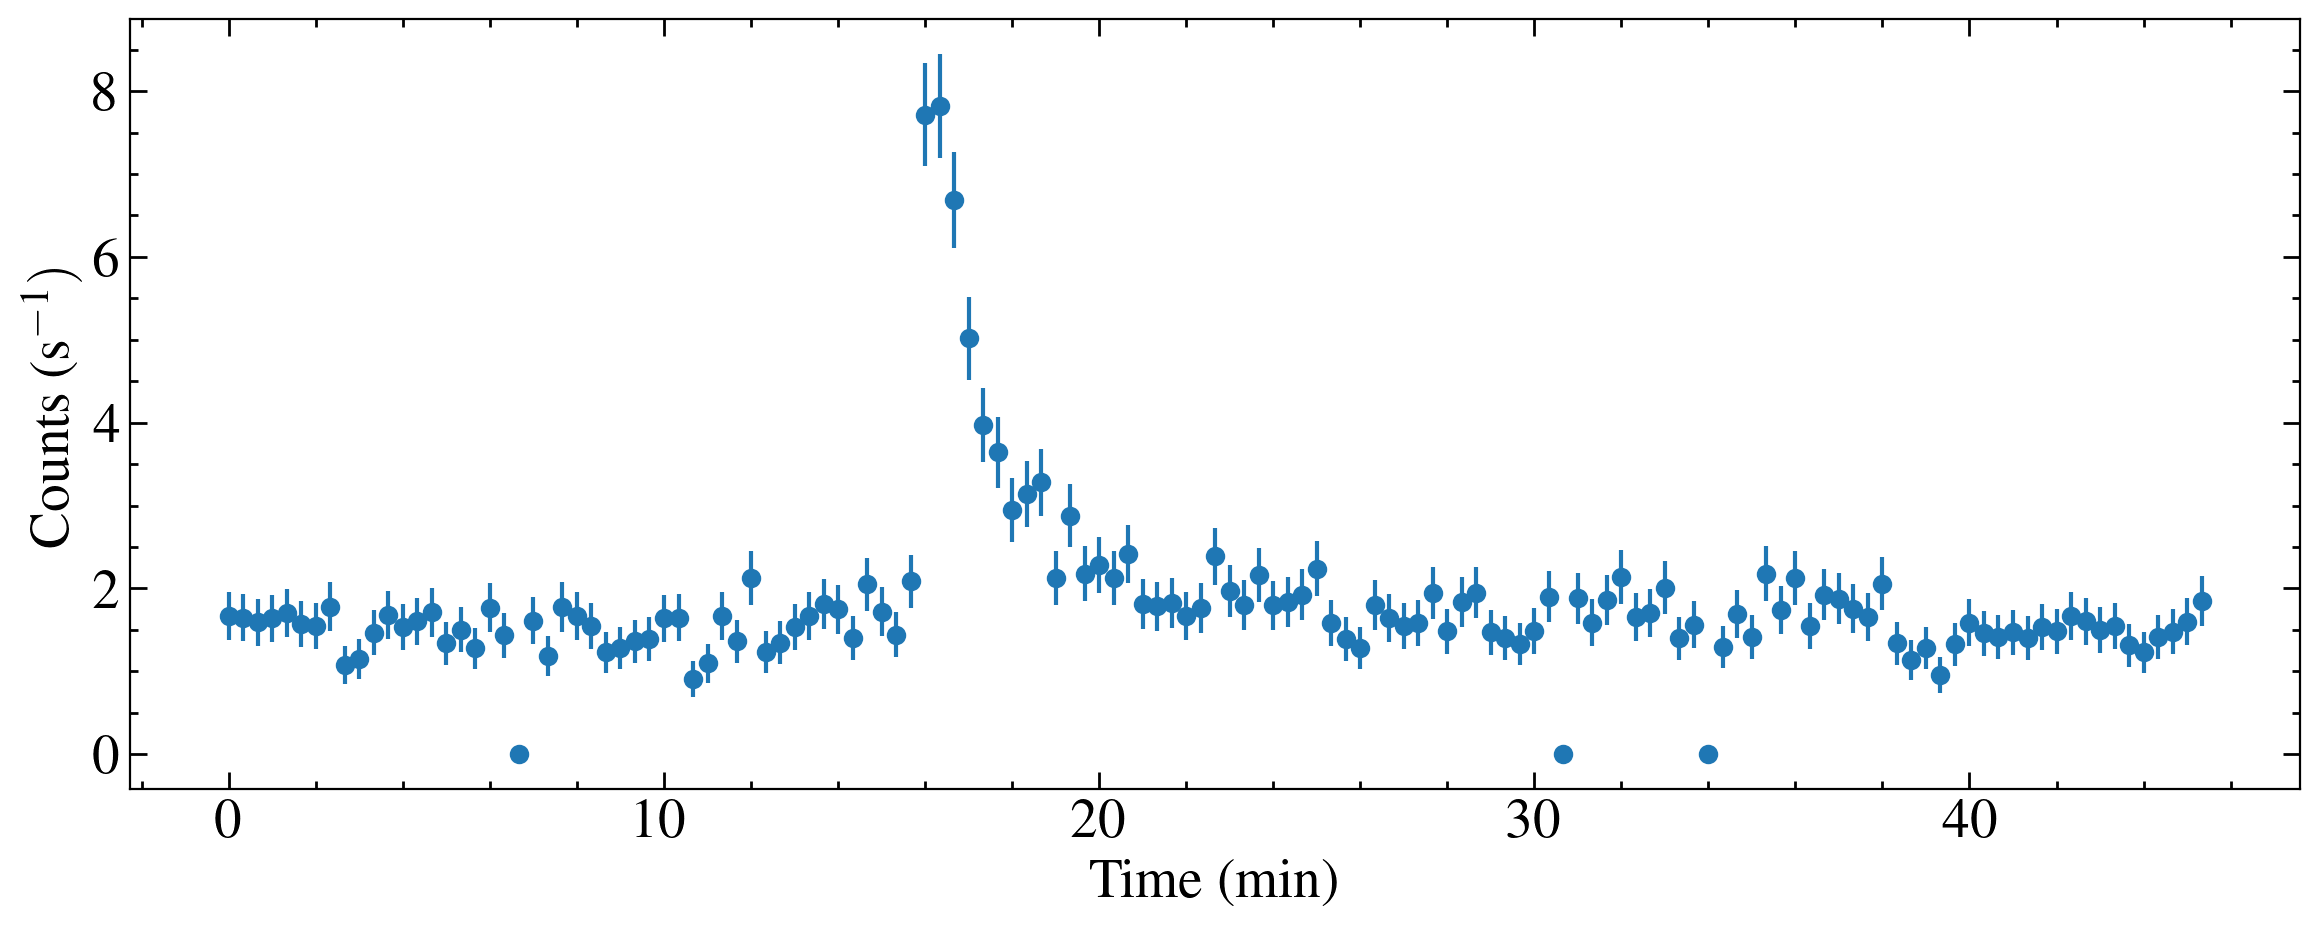

In [88]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

for x in new_x1ds:   
    fig, ax = plt.subplots()
    hdul = fits.open(x)
    print(hdul[0].header['TARGNAME'])
    time = []
    flux = []
    error = []
    error_sqrt = []
    hdul = fits.open(x)
    band = [1250, 1700]
    for ext in hdul[1::]:
        data = ext.data[0]
        hdr = ext.header
        ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
        time.append(ti)
        w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
        #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
        w0, w1 = wavelength_edges(w) 
        mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
        w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
        fi = np.sum(f*(w1-w0))
        ei = (np.sum(e**2 * (w1-w0)**2))**0.5
        flux.append(fi)
        error.append(ei)
        ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
        error_sqrt.append(ei) #better approach for these low-signal spectra
        
        
    
    hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error_sqrt, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')
    plt.show()
    
    # print(hdul[0].header['ROOTNAME'])
    # for ext in hdul[1::]: #spectra in every extension after the first
    #     data = ext.data[0]
    #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
    #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
    #     ax.set_ylim(0, 1.1*max(data['FLUX']))
    #     # plt.show()
    # hdul.close()
    # plt.show()
    

In [63]:
# plt.plot(w, f)
# plt.plot(w, e)

nice flare in LHS 2686, quick look at TESS TIC 198511612. Nothing much happening

In [61]:
# import lightkurve as lk
# search_result = lk.search_lightcurve('TIC 198511612')
# search_result

In [62]:
# lc120s = []
# for i, sr in enumerate(search_result):
#     if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
#         # print(i)
#         lc120s.append(i)
# #         print(sr./#[0])
#         lc = sr.download(download_dir='mastDownload/')
#         lc.remove_outliers().plot()
# # print(lc120s)

In [77]:
savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/light_curves/'

GJ649


/tmp/ipykernel_22885/3962446135.py:37: RuntimeWarning: invalid value encountered in scalar power
  ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts


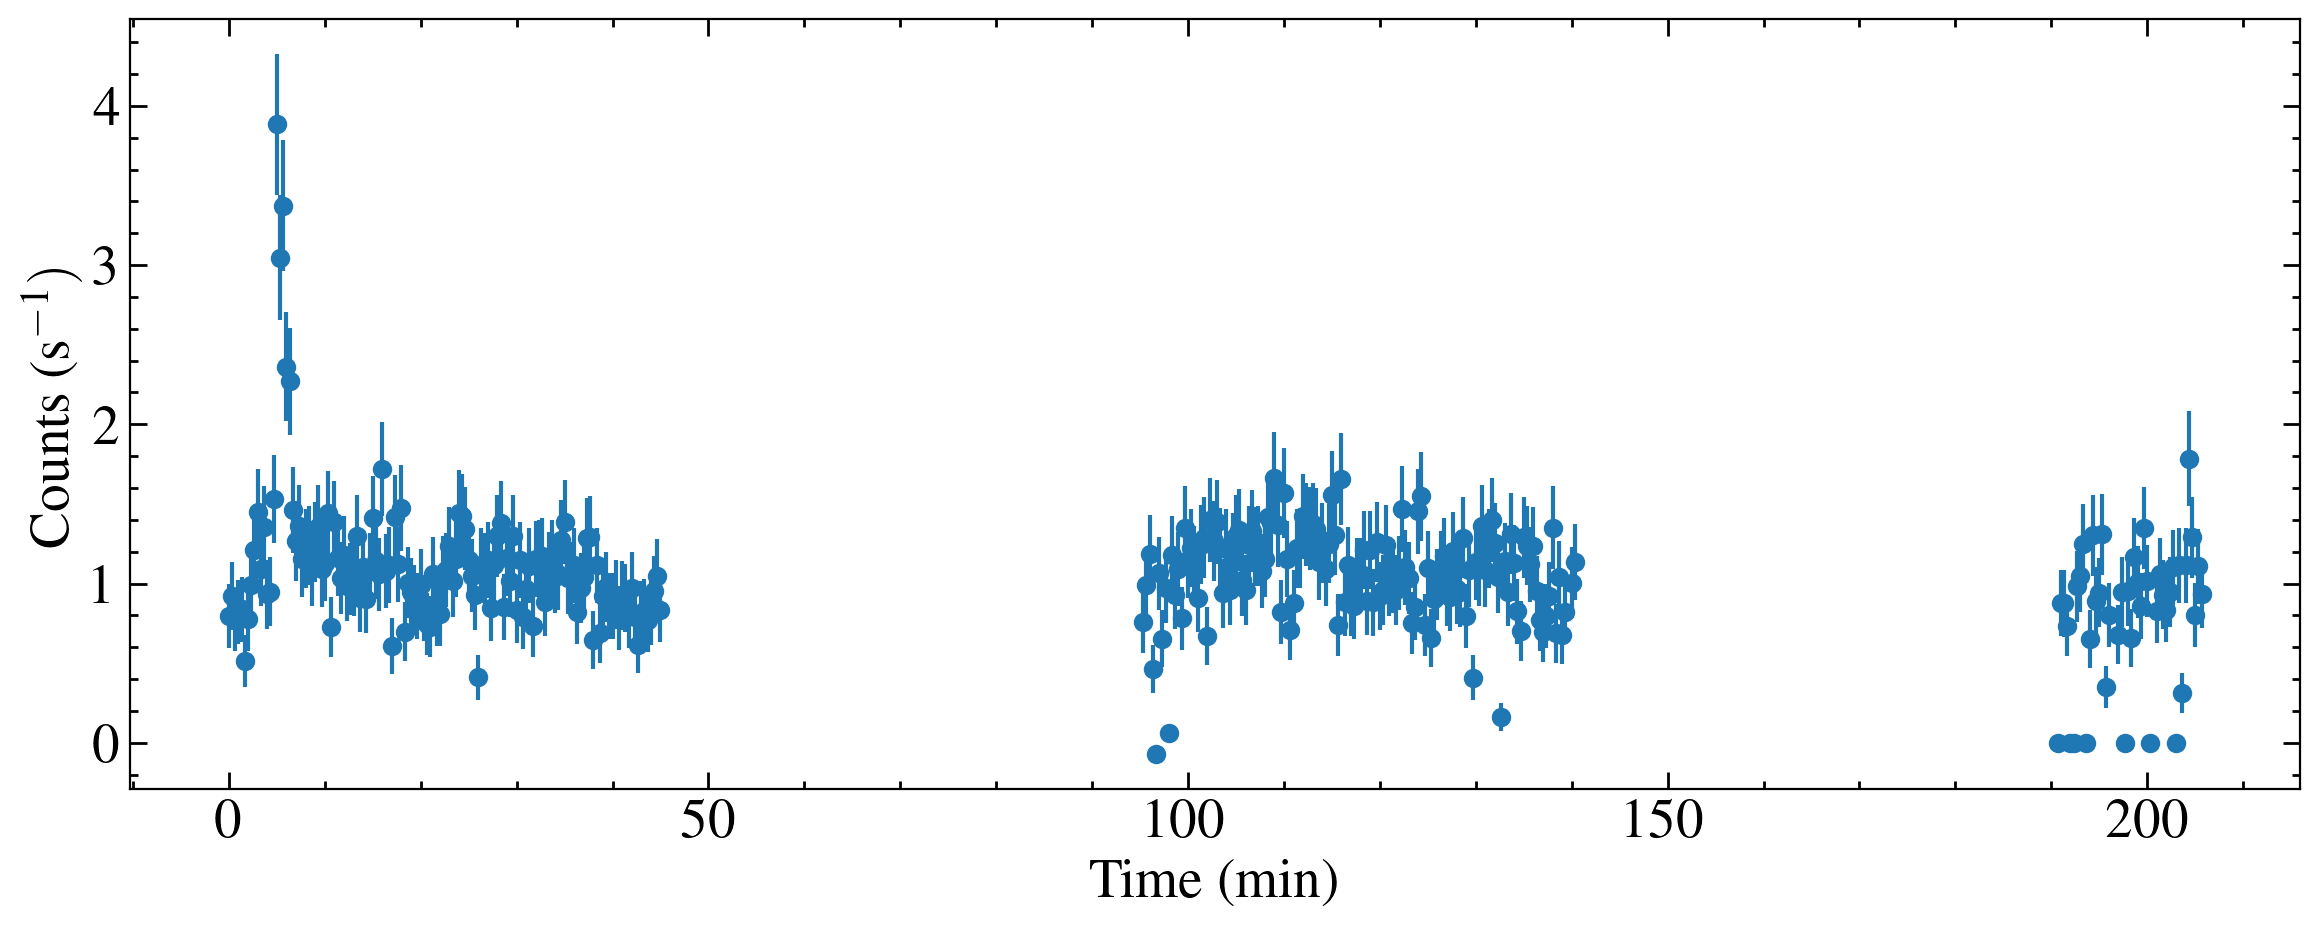

GJ674


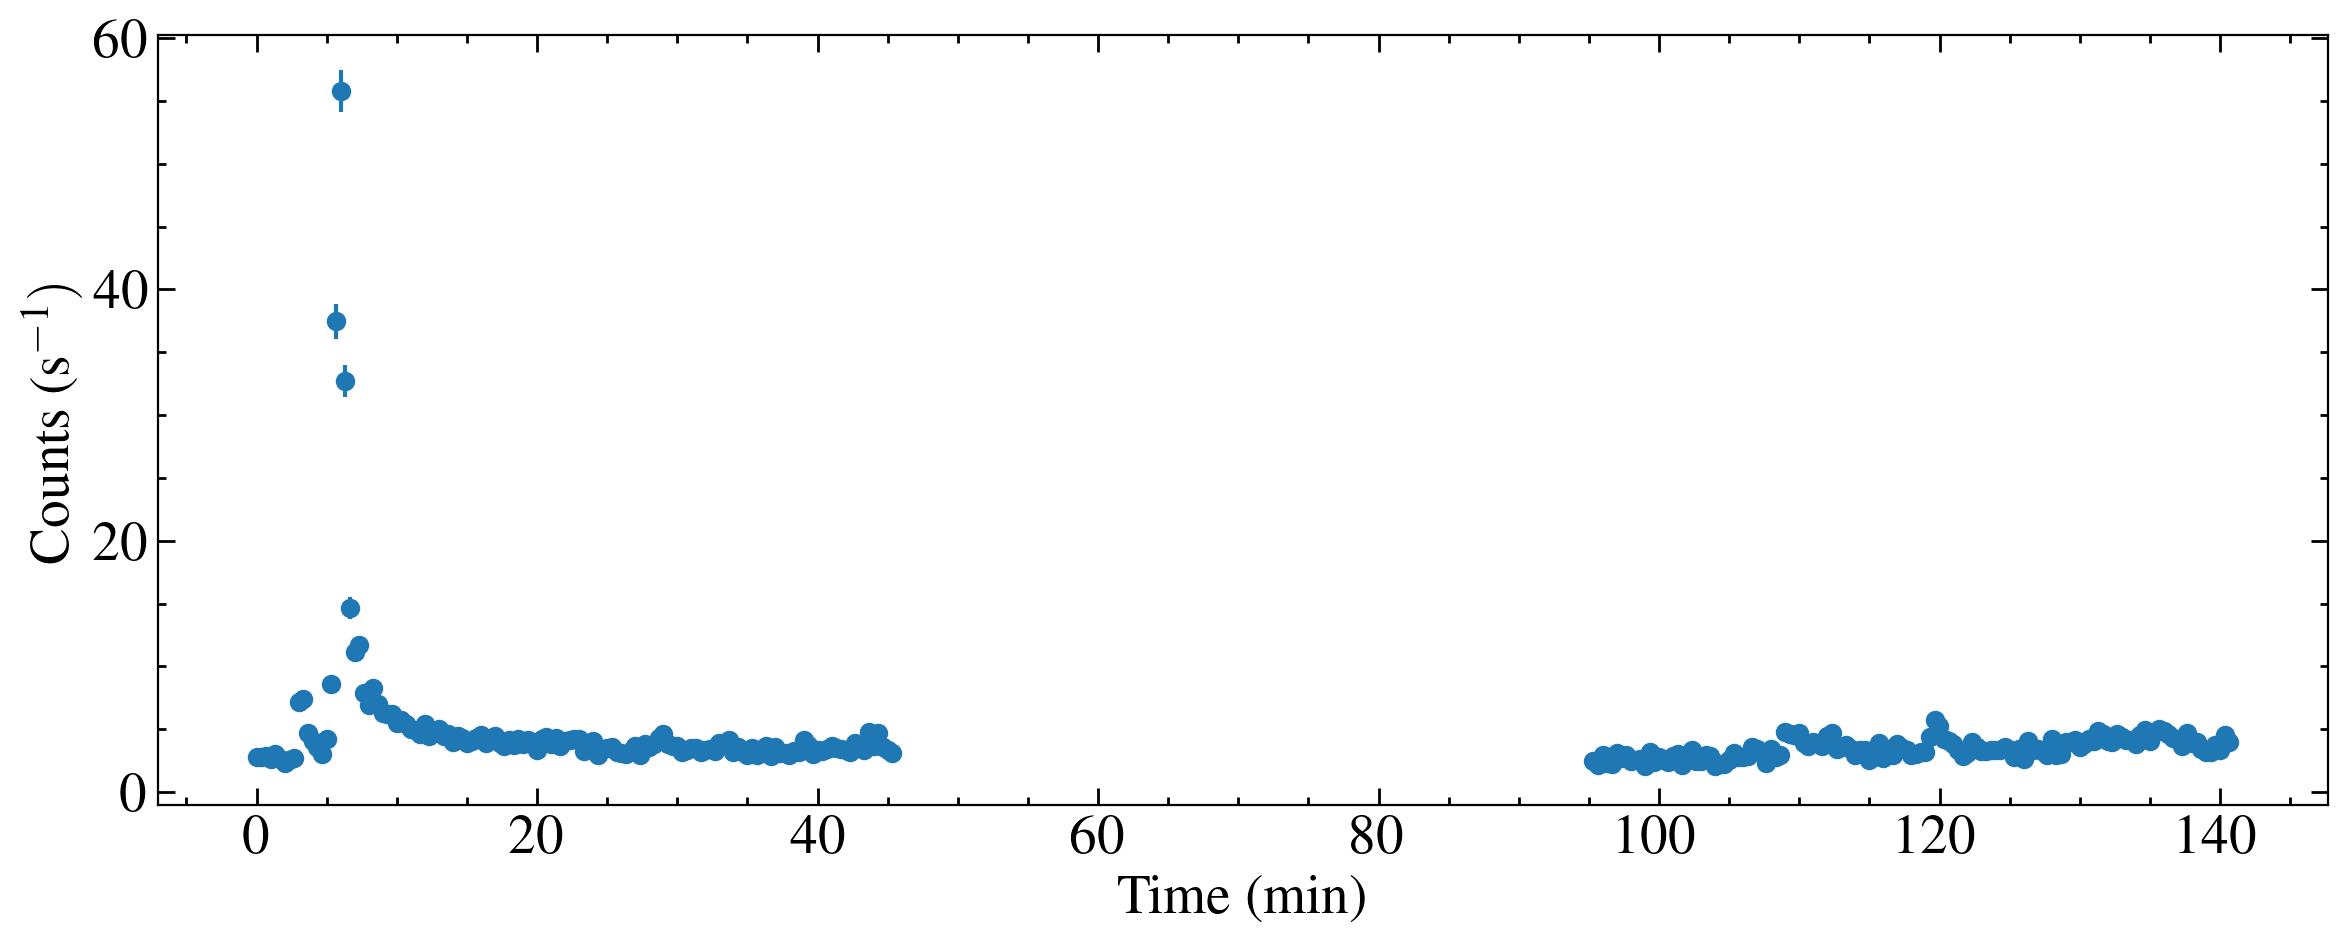

GJ676A


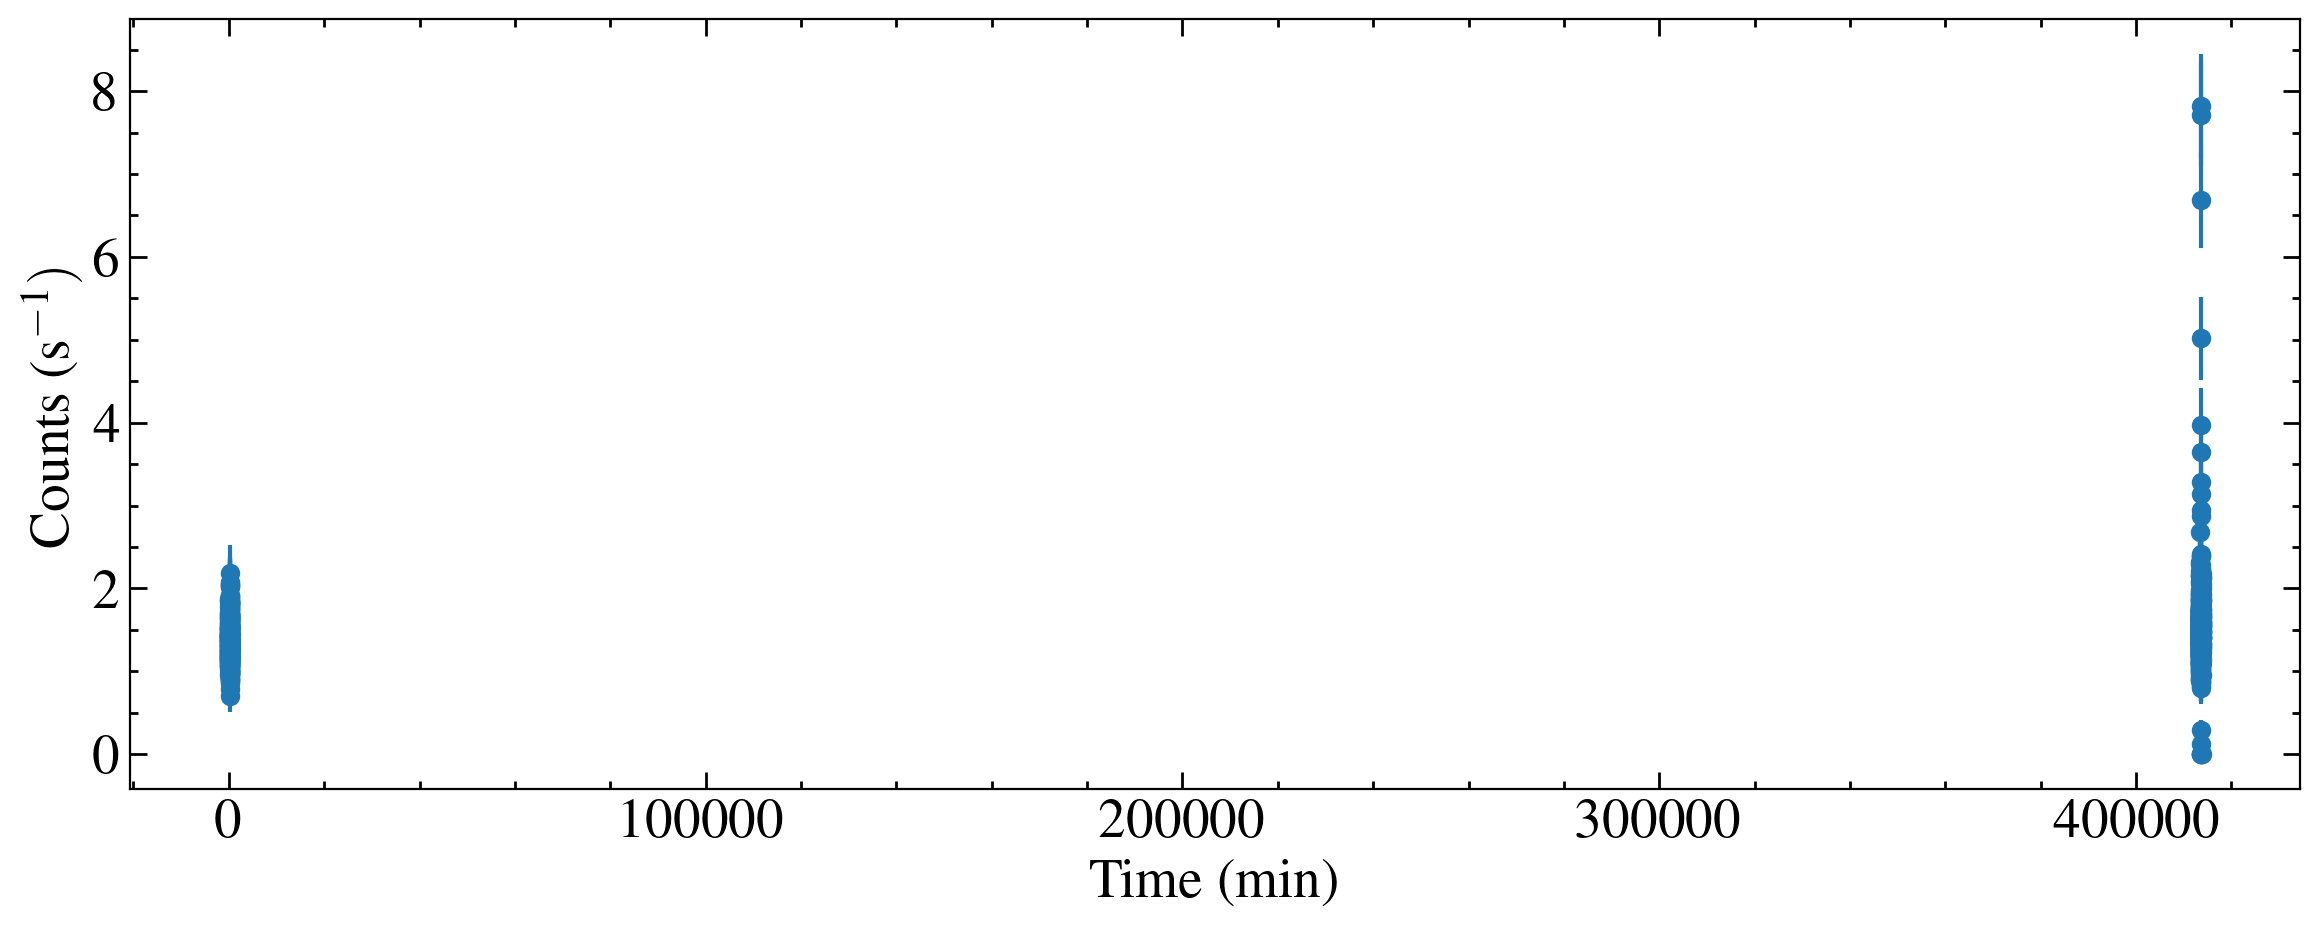

GJ699


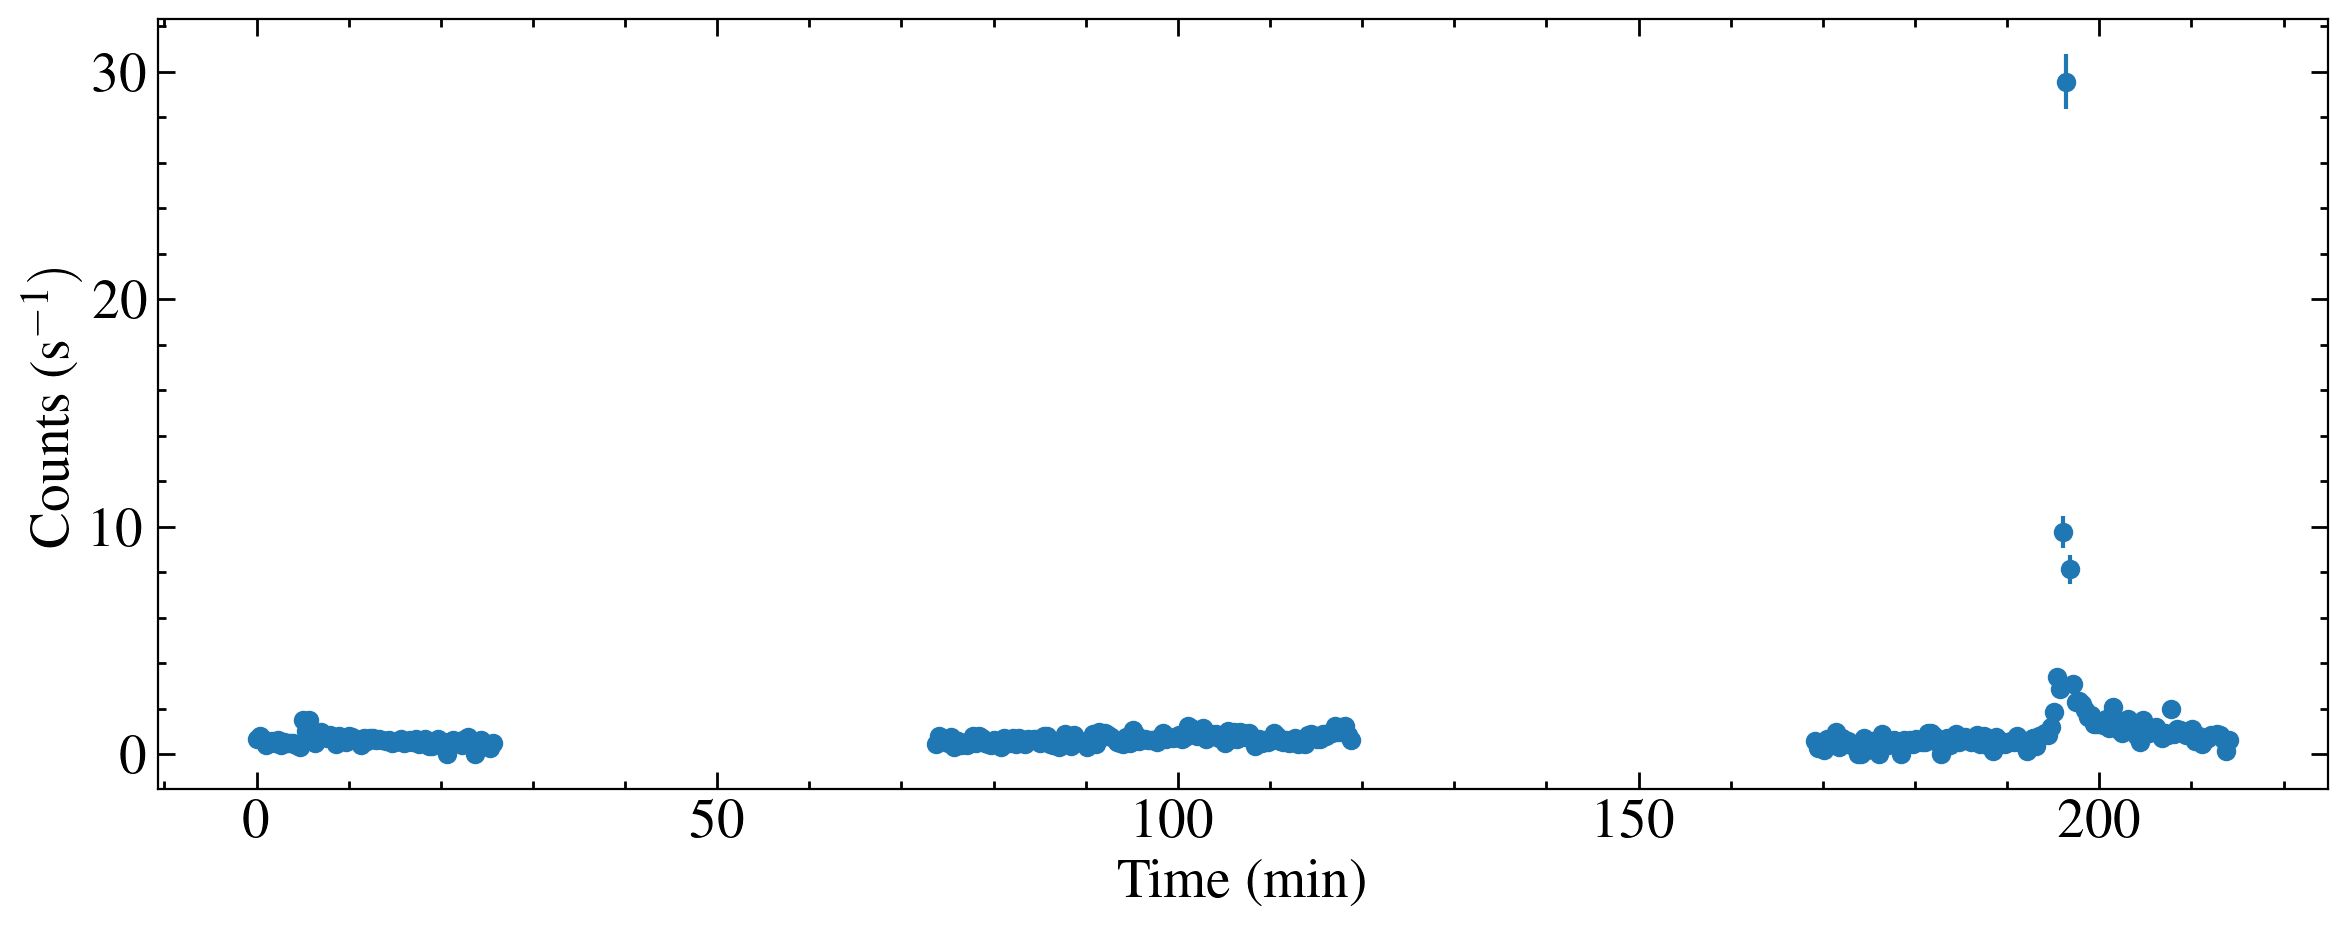

LHS-2686


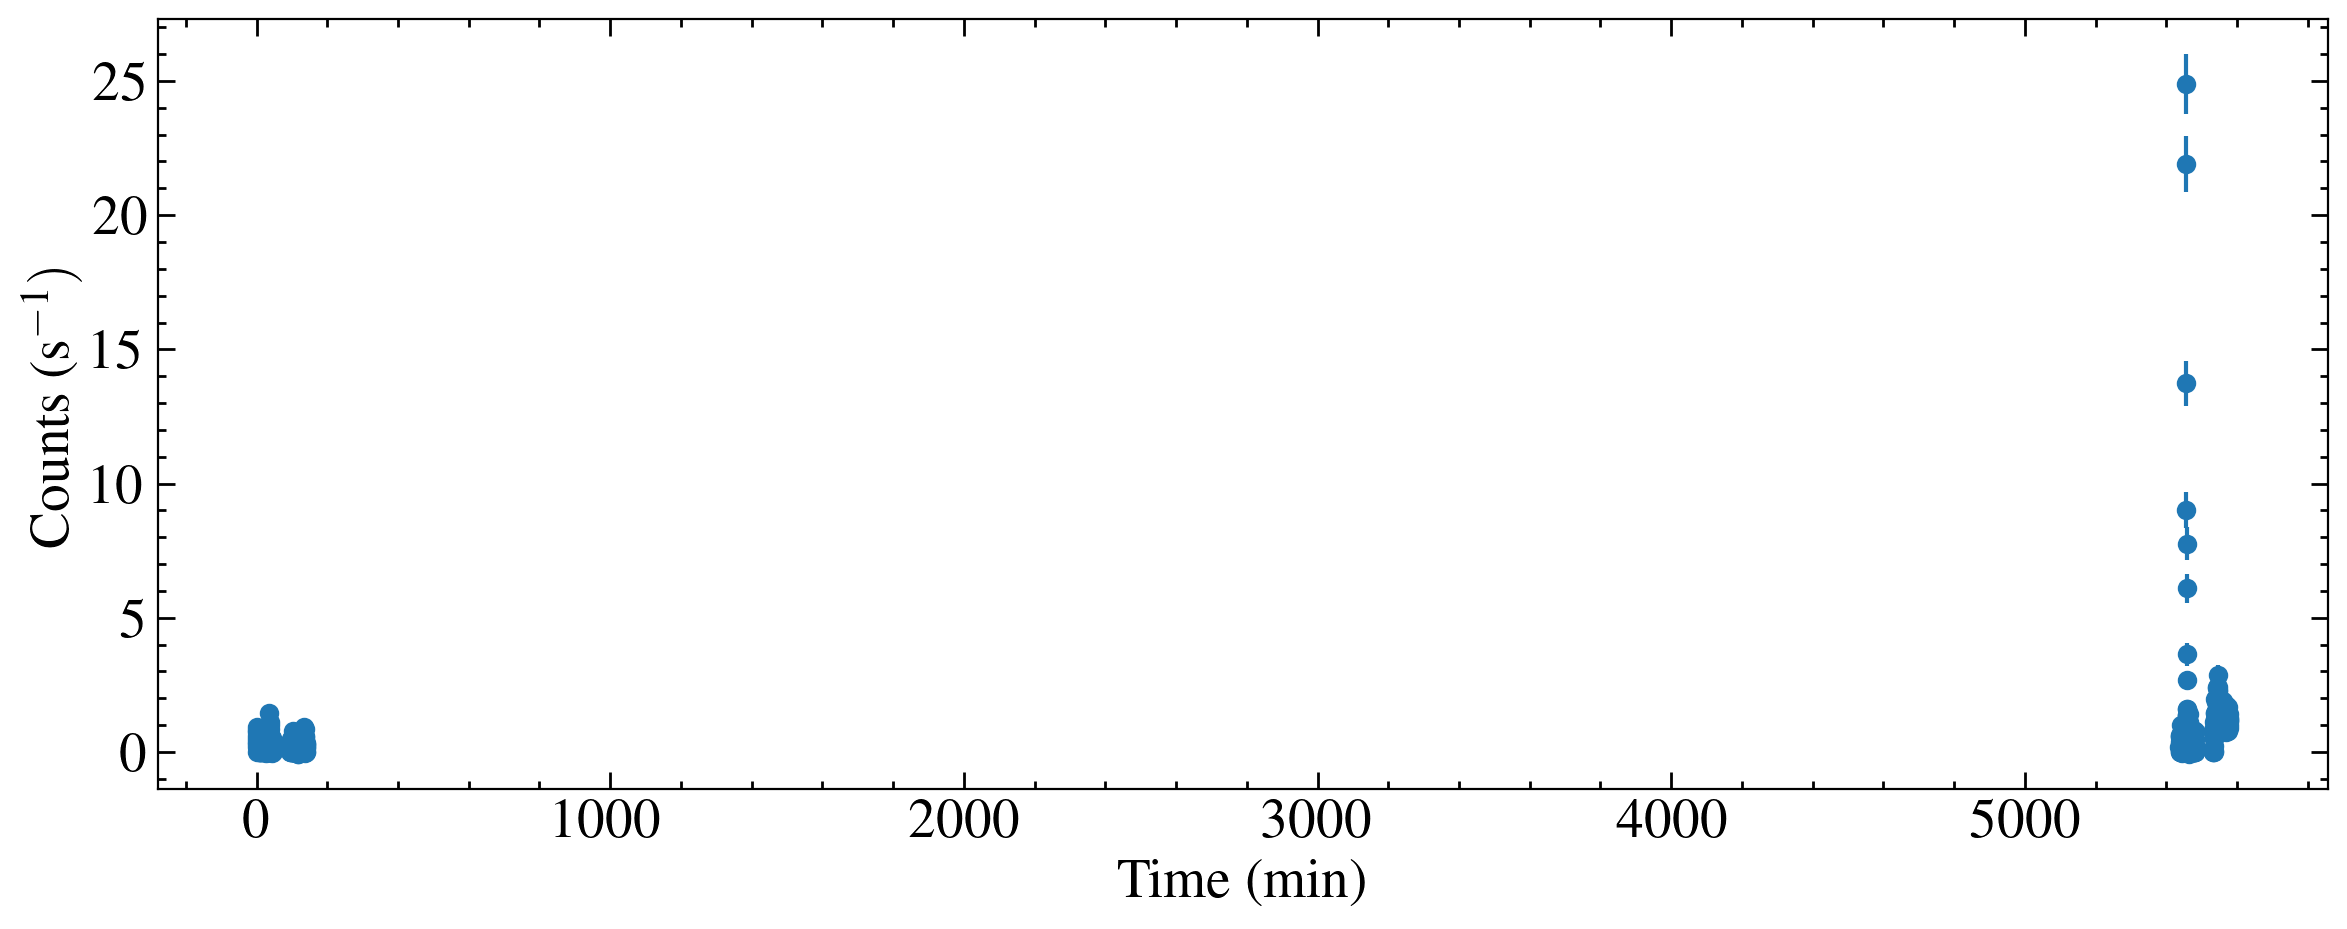

In [79]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

band = [1250, 1700]

for star in stars:
    print(star)
    fig, ax = plt.subplots()
    time = []
    flux = []
    error = []
    for x in new_x1ds:   
        hdul = fits.open(x)
        if hdul[0].header['TARGNAME'] == star: 
            for ext in hdul[1::]:
                data = ext.data[0]
                hdr = ext.header
                ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
                time.append(ti)
                w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
                #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
                w0, w1 = wavelength_edges(w) 
                mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
                w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
                fi = np.sum(f*(w1-w0))
                # ei = (np.sum(e**2 * (w1-w0)**2))**0.5
                flux.append(fi)
                # error.append(ei)
                ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
                error.append(ei) #better approach for these low-signal spectra
                
                
        
        hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    args = np.argsort(time)
    time, flux, error = time[args], flux[args], error[args]
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')
    plt.show()

    savdat = Table([time*cds.MJD, flux/u.s, error/u.s], names=['MJD', 'COUNTS', 'COUNTS_ERROR'])
    savdat.write('{}{}_{}_{}s_lc.ecsv'.format(savepath, star, grating, t_bin))
    
        # print(hdul[0].header['ROOTNAME'])
        # for ext in hdul[1::]: #spectra in every extension after the first
        #     data = ext.data[0]
        #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
        #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
        #     ax.set_ylim(0, 1.1*max(data['FLUX']))
        #     # plt.show()
        # hdul.close()
        # plt.show()
        